# London to Lakes

[1. Defining the Problem Space](#1.-Defining-the-Problem-Space)
- [1.1 Possible Journeys](#1.1-Possible-Journeys)
- [1.2 Calculate Journey Reward Scores](#1.2-Calculate-Journey-Reward-Scores)
- [1.3 Create Reward Matrix to Learn](#1.3-Create-Reward-Matrix-to-Learn)

[2. Implement Q-Learning](#2.-Implement-Q-Learning)
- [2.1 Define Functions](#2.1-Define-Functions)
- [2.2 Test Parameters and Constant Decay Factor](#2.2-Test-Greedy-Constant)
- [2.3 Test Parameters and Modulated Decay Factor](#2.3-Test-Greedy-Modulated)

[3. Grid Search over Epsilon and Constant Decay Rate](#3.-Grid-Search-Over-Epsilon-and-Decay-Rate)
- [3.1 Inspect Effect on Convergence Rate](#3.1-Convergence-Rate)
- [3.2 Inspect Effect on Evolution of Episode Q-Scores](#3.2-Q-Scores)

[4. Grid Search over Alpha and Gamma](#4.-Grid-Search-Over-Alpha-and-Gamma)
- [4.1 Inspect Effect on Convergence Rate](#4.1-Convergence-Rate)
- [4.2 Inspect Effect on Evolution of Episode Q-Scores](#4.2-Q-Scores)

[5. Modifying the Reward Function](#5.-Modify-Reward)
- [5.1 Optimise for Lowest Cost](#5.1-Optimise-Cost)
- [5.2 Optimise for Shortest Duration](#5.2-Optimise-Duration)

[6. Modifying the Problem Space](#6.-Modify-States)
- [6.1 Grid Search over Epsilon and Constant Decay Rate](#6.1-Grid-Search-Over-Epsilon-and-Decay-Rate)
- [6.1 Grid Search over Alpha and Gamma](#6.2-Grid-Search-Over-Alpha-and-Gamma)


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import time
from IPython.display import Image
from IPython.core.display import HTML 

random.seed(100)
np.set_printoptions(suppress=True)

<a id='1.-Defining-the-Problem-Space'></a>

## 1. Defining the Problem Space

 - The agent must learn the 'best' journey from London to the Lake District.
 - One episode is one completed journey, via any route.
 - Each leg of the journey provides a reward, a function of journey duration, cost and number of train changes.
 - The optimal journey with highest episode reward, minimises all three of these factors.
 - A greedy search algorithm runs through 1,000 episodes, updating the Q-matrix with learned rewards.
 - For each episode, the sum of the rewards for each leg of the journey is recorded, 'episode_Q'.

<a id='1.1-Possible-Journeys'></a>

### 1.1 Possible Journeys

The following graph and table display the possible journeys the agent can take, with the associated journey time and cost.

In [2]:
Image(url= "https://raw.githubusercontent.com/Stephanie-Jury/Software-Agents/master/Domain.png")

In [186]:
# Read the base matrix csv which contains all the meta data for each possible journey
base_matrix_url = "https://raw.githubusercontent.com/Stephanie-Jury/Software-Agents/master/base_matrix.csv"
df_base_matrix = pd.read_csv(base_matrix_url)
df_base_matrix

,Source,Target,SourceID,TargetID,Duration,Cost,Platform Change
0,London,Birmingham Moor Street,0,2,204,20.00,1
1,London,Banbury,0,1,118,18.90,1
2,London,Reading,0,4,28,27.40,1
3,London,Sheffield,0,5,134,56.50,1
4,London,Preston,0,7,202,89.40,1
5,London,Oxenholme,0,8,102,105.20,1
6,Banbury,Birmingham New Street,1,3,86,12.86,1
7,Banbury,Reading,1,4,44,12.50,1
8,Birmingham Moor Street,Birmingham New Street,2,3,14,6.11,1
9,Birmingham New Street,Manchester Piccadilly,3,6,78,18.52,1


<a id='1.2-Calculate-Journey-Reward-Scores'></a>

### 1.2 Calculate Journey Reward Scores

The reward score for each leg of the journey is a weighted contribution of the journey time, cost and number of train changes.

In [187]:
# Start by adding a reward column to the base matrix
df_base_matrix['Reward Score'] = 0
df_base_matrix.head(3)

# Set importance of each factor for the reward function
weight_duration = 1  # Set weight of journey duration term
weight_train_change = 1  # Set weight of changing train term
weight_cost = 1  # Set weight of journey cost term

for i in range(0, len(df_base_matrix)):

    # Select journey characteristics
    duration = df_base_matrix['Duration'][i]
    train_change = df_base_matrix['Platform Change'][i]
    cost = df_base_matrix['Cost'][i]

    # Calculate total reward for journey (weighted sum of rewards from train change, journey cost and duration)

    # 1. Calculate reward for journey duration
    if (duration == 0):
        reward_duration = 0
    elif (0 < duration <= 60):
        reward_duration = 15
    elif (60 < duration <= 120):
        reward_duration = 10
    elif (120 < duration <= 180):
        reward_duration = 5
    elif (180 < duration <= 240):
        reward_duration = 1
    else:
        reward_duration = -1

    # 2. Calculate reward (penalty) for each change
    if (train_change == 1):
        reward_train_change = -10
    else:
        reward_train_change = 0

    # 3. Calculate reward for the cost of the journey
    if (cost == 0):
        reward_cost = 0
    elif (0 < cost <= 10):
        reward_cost = 15
    elif (10 < cost <= 30):
        reward_cost = 14
    elif (30 < cost <= 40):
        reward_cost = 13
    elif (40 < cost <= 60):
        reward_cost = 12
    elif (60 < cost <= 80):
        reward_cost = 10
    elif (80 < cost <= 90):
        reward_cost = 7
    elif (90 < cost <= 100):
        reward_cost = 4
    elif (100 < cost <= 110):
        reward_cost = 1
    else:
        reward_cost = -1

    # Combine total reward
    reward = weight_duration*reward_duration + weight_train_change * \
        reward_train_change + weight_cost*reward_cost

    # Update the base matrix with the reward
    df_base_matrix['Reward Score'][i] = reward

# Check the updated base matrix
df_base_matrix

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Source,Target,SourceID,TargetID,Duration,Cost,Platform Change,Reward Score
0,London,Birmingham Moor Street,0,2,204,20.00,1,5
1,London,Banbury,0,1,118,18.90,1,14
2,London,Reading,0,4,28,27.40,1,19
3,London,Sheffield,0,5,134,56.50,1,7
4,London,Preston,0,7,202,89.40,1,-2
5,London,Oxenholme,0,8,102,105.20,1,1
6,Banbury,Birmingham New Street,1,3,86,12.86,1,14
7,Banbury,Reading,1,4,44,12.50,1,19
8,Birmingham Moor Street,Birmingham New Street,2,3,14,6.11,1,20
9,Birmingham New Street,Manchester Piccadilly,3,6,78,18.52,1,14


<a id='1.3-Create-Reward-Matrix-to-Learn'></a>

### 1.3 Create Reward Matrix to Learn

In [188]:
# Use reward scores to generate a final 8 x 8 reward matrix of all possible journey options
np_reward_matrix = np.zeros(shape=(10, 10))

for i in range(0, len(df_base_matrix)):
    s = int(df_base_matrix['SourceID'][i])
    t = int(df_base_matrix['TargetID'][i])
    np_reward_matrix[s, t] = df_base_matrix['Reward Score'][i]

reward_matrix = np_reward_matrix

# Add additional rewards for nearing goal state
reward_matrix[7, 9] = reward_matrix[7, 9] + 150
reward_matrix[8, 9] = reward_matrix[8, 9] + 150

# Add additional reward +10 for reaching one step before goal state
reward_matrix[0, 7] = reward_matrix[0, 7] + 10
reward_matrix[0, 8] = reward_matrix[0, 8] + 10
reward_matrix[6, 7] = reward_matrix[6, 7] + 10
reward_matrix[7, 8] = reward_matrix[7, 8] + 10

# (Visualise as dataframe)
df_reward_matrix = pd.DataFrame(np_reward_matrix)
df_reward_matrix.columns = [
    'London', 'Banbury', 'Birmingham Moor Street', 'Birmingham New Street',
    'Reading', 'Sheffield', 'Manchester Piccadilly', 'Preston', 'Oxenholme',
    'Lakes'
]

df_reward_matrix.rename(
    index={
        0: 'London',
        1: 'Banbury',
        2: 'Birmingham Moor Street',
        3: 'Birmingham New Street',
        4: 'Reading',
        5: 'Sheffield',
        6: 'Manchester Piccadilly',
        7: 'Preston',
        8: 'Oxenholme',
        9: 'Lakes',
    },
    inplace=True)
df_reward_matrix

,London,Banbury,Birmingham Moor Street,Birmingham New Street,Reading,Sheffield,Manchester Piccadilly,Preston,Oxenholme,Lakes
London,0.0,14.0,5.0,0.0,19.0,7.0,0.0,8.0,11.0,0.0
Banbury,0.0,0.0,0.0,14.0,19.0,0.0,0.0,0.0,0.0,0.0
Birmingham Moor Street,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
Birmingham New Street,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0
Reading,0.0,0.0,0.0,19.0,0.0,3.0,0.0,0.0,0.0,0.0
Sheffield,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0
Manchester Piccadilly,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0
Preston,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,175.0
Oxenholme,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,178.0
Lakes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id='2.-Implement-Q-Learning'></a>

## 2. Implement Q-learning

 - We use an epsilon-greedy policy to update the Bellman equation sequentially and learn the reward matrix.
 - The algorithm is initially set to explore (epsilon_greedy = 1), with a decay parameter (epsilon_greedy_rate = 0.900).
 - After each episode, the Q-matrix (Q_matrix_new) is updated and checked against the previous Q-matrix (Q_matrix_old). If after 15 episodes, these two matrices have remained equivalent, we state that the algorithm has converved.
 - Once the algorithm has converged, the epsilon-greedy policy is altered to exploit, switching to a larger decay parameter (epsilon_greedy_rate_exploit = 0.500).

<a id='2.1-Define-Functions'></a>

### 2.1 Define Functions

In [106]:
# Function to select to explore or exploit based on probability Epsilon
def funcExploreAndExploit(epsilon):
    # Explore : 1 and Exploit : 0
    random_number = round(10 * random.uniform(0, 1))
    epsilon = epsilon * 10
    if random_number <= epsilon:
        return 1
    return 0

In [107]:
# Starting at location 0, iterate through all the state transitions in an episode until reaching location 7.
# Update Q matrix with new Q Value

def funcEpisode(episode_convergence, current_state, Q_matrix_old, Q_matrix_new,
                greedy_epsilon, alpha_learning_rate, gamma_discount_factor):

    state_count = 0
    episode_policy = [current_state]
    episode_Q_value = 0
    explore_list = []
    target_state = 0

    # While the agent has not reached the Lakes
    while target_state < 9:

        # 1. SELECT NEXT DESTINATION FROM CURRENT STATE -----------------------------------

        # Randomly decide whether to explore or exploit when choosing the next destination
        explore = funcExploreAndExploit(greedy_epsilon)
        
        # Append this journey's explore/exploit status to the explore list
        explore_list.append(explore)

        # IF EXPLORATION: select a random target destination from the list
        # of targets which are possible to reach from the current location (current_state)
        if (explore == 1):

            # Find possible targets available given current_state, using the base matrix
            targets_available = df_base_matrix[df_base_matrix['SourceID'] ==
                                               current_state]
            TargetList = targets_available['TargetID']
            targetList = TargetList.tolist()

            # Randomly select the next target
            destinationId = random.choice(targetList)
            target_state = destinationId
        
        # IF EXPLOITATION: select the target which gives maximum expected return (Q Value)
        else:
            # Find possible targets available given current_state, using the base matrix
            targets_available = df_base_matrix[df_base_matrix['SourceID'] ==
                                               current_state]
            TargetList = targets_available['TargetID']
            TargetList = TargetList.tolist()

            # For each possible target that is available from the current state, carry out a greedy search
            # for the target with the highest known reward (greedy target).(Method: sequentially compare
            # the learned reward of each possible move, storing the higher of the two rewards.)
            maxQValue = 0  # Set initial value to compare reward against at 0
            GreedyTarget = 0  # Initialise greedy target variable

            # CHANGE TO ARGMAX            
            target_temp = []
            maxQValue_temp = []
            for t, target in enumerate(TargetList):
                maxQValue_temp.append(Q_matrix_old[current_state, target])
                target_temp.append(t)

            maxQValue = max(maxQValue_temp)
            GreedyTarget_idx = maxQValue_temp.index(max(maxQValue_temp))
            GreedyTarget = TargetList[GreedyTarget_idx]

            # Set target state to the target with the highest reward
            target_state = GreedyTarget

        # Add the selected target destination to the episode's policy
        episode_policy.append(target_state)
        #print('episode_policy = ', episode_policy)

        # 2. CALCULATE NEW Q VALUE AND UPDATE Q MATRIX ------------------------------------

        # Get old Q-value of the current state and selected target
        Q_old = Q_matrix_old[current_state, target_state]

        # Get reward for the current state and selected target
        current_state_reward = reward_matrix[current_state, target_state]

        # Find possible next targets available given the chosen target, using the base matrix
        targets_available = df_base_matrix[df_base_matrix['SourceID'] ==
                                           target_state]
        TargetList = targets_available['TargetID']
        targetOfTargetList = TargetList.tolist()

        # Calculate the maximum expected cumulative reward/Q-value from chosen target to possible next targets
        Q_temp = np.zeros(shape=(len(targetOfTargetList), 1))
        for i in range(0, len(targetOfTargetList)):
            Q_temp[i] = Q_matrix_old[target_state, i]
        Q_max = max(Q_temp)

        # Update the Q value using the Bellman equation
        Q_new = Q_old + alpha_learning_rate * ((current_state_reward + (gamma_discount_factor * Q_max))-Q_old)
        Q_new_round = np.round(Q_new, decimals=4)
        Q_new = Q_new_round
        #print('Q_old = ',Q_old,'Q_new',Q_new)

        # Update new Q matrix with the new Q value
        Q_matrix_new[current_state, target_state] = Q_new

        # Add the new Q value to the total episode Q
        episode_Q_value += Q_new
        
        # 3. SET CONDITIONS FOR NEXT ITERATION OR NEXT EPISODE ----------------------------

        # Update the current state as the target state because in next intration it will act as source
        current_state = target_state

        # Check if algorithm has reached the final destination
        # If at final destination, stop the learning episode and set episode convergence = 1
        if (target_state == 9):
            episode_convergence = 1
        else:
            episode_convergence = 0

        # Update the Q matrix
        Q_old = Q_new
        
        # Episode policy
        #print('Policy',episode_policy,'Q Score',episode_Q_value)
        
    return episode_Q_value[0]

In [108]:
def funcVariablesReset():
    # Q matrix (old and new) starts as an array of zeros
    Q_matrix_old = np.zeros(shape=(10, 10))
    Q_matrix_new = np.zeros(shape=(10, 10))

    # Initialise start location #0 (London)
    start_location = 0

    # Set current state to start location (current state updates inside each episode loop)
    current_state = start_location

    # Set algorithm convergence status
    # (0: not converged/Q matrix still changing?, 1: converged/no more Q matrix change?)
    algorithm_convergence = 0

    # Set epsiode convergence state
    # (0: not converged/not at destination, 1: converged/at destination)
    episode_convergence = 0

    # Set learning episode number
    episode = 0
    return(Q_matrix_old, Q_matrix_new, start_location, current_state, algorithm_convergence, episode_convergence, episode)

<a id='2.2-Test-Greedy-Constant'></a>

### 2.2 Test Parameters using Constant Decay Factor

In [189]:
# Initialise epsilon and epsilon decay rate (greedy_epsilon = greedy_epsilon - greedy_epsilon_rate)
greedy_epsilon = 1
greedy_epsilon_rate = 0.1

# Initialise alpha and gamma
alpha_learning_rate = 0.5
gamma_discount_factor = 0.5

# Initisalise convergence parameter, the number of episodes Q_mat_new and Q_mat_old stay the same
convergence_parameter = 15

# Initialise array to store episode rewards 
episode_Q_store = []

# Set maximum number of episodes to test
max_episode_count = 300

# Set number of trial samples to average
trial_samples = 50

#Reset variables
[Q_matrix_old, Q_matrix_new, start_location, current_state,
 algorithm_convergence, episode_convergence, episode] = funcVariablesReset()
convergence_episode = 0
convergence_episode_temp = 0
convergence_episode_store = []
reward_matrix_learning = [0]*reward_matrix
Q_matrix_new_sum_store = []
first = True

while episode <= max_episode_count-1:
#and np.sum(reward_matrix_learning) < len(reward_matrix): 
    
    episode_Q_value_trial_store = []
    
    for t in range(1, trial_samples+1):
        # Iterate through each episode (full journey from London to Lakes)
        episode_Q_value = funcEpisode(
            episode_convergence, current_state, Q_matrix_old, Q_matrix_new,
            greedy_epsilon, alpha_learning_rate, gamma_discount_factor)
        
        episode_Q_value_trial_store.append(episode_Q_value)
    
    episode_Q_value_mean = np.mean(episode_Q_value_trial_store)
    
    Q_matrix_new_sum_store.append(round(np.sum(Q_matrix_new),1))

    #Update the Q score for that episode
    episode_Q_store.append(episode_Q_value_mean)

    #Record max Q value
    episode_max_Q = max(episode_Q_store)

    # Reduce the greedy epsilon by greedy epsilon rate
    greedy_epsilon = greedy_epsilon * (1 - greedy_epsilon_rate)

    # Prevent greedy epsilon from becoming negative
    if greedy_epsilon < 0:
        greedy_epsilon = 0
    
    # Check if all possible paths have been explored
    if np.count_nonzero(reward_matrix) == np.count_nonzero(Q_matrix_old): 

        # If so, check if the new Q matrix is equivalent to the previous episode's
        if np.array_equiv(np.round(Q_matrix_new, decimals=3), np.round(Q_matrix_old, decimals=3)):  
            convergence_episode_temp = episode
            convergence_episode_store.append(convergence_episode_temp)
        else:
            convergence_episode_store.append(0)
            #print('Conv_ep',episode,'Qmatnewsum',round(np.sum(Q_matrix_new),1))
    else:
        convergence_episode_store.append(0)
        #print('Conv_ep',episode,'Qmatnewsum',round(np.sum(Q_matrix_new),1))

    # Update Old Q matrix with new one for next iteration
    np.copyto(Q_matrix_old, Q_matrix_new)

    # Update the number of full journeys made
    episode +=1

    # If there have been more episodes than the convergence parameter
    if episode >= convergence_parameter:

        # Check if the value in the episode convergence store, convergence parameter positions previously is the same
        if Q_matrix_new_sum_store[episode-1] == Q_matrix_new_sum_store[episode-convergence_parameter]:

            # If the first time the previous condition has been met
            if first == True:
                # Update the convergence episode number
                convergence_episode = episode - convergence_parameter
                print('Algorithm converged in %d episodes' % convergence_episode)
                first = False
    else:
        convergence_episode = 0        

Algorithm converged in 14 episodes


In [110]:
# Visualise learned Q matrix as dataframe
df_learned_Q_matrix = pd.DataFrame(Q_matrix_new)
df_learned_Q_matrix.columns = [
    'London', 'Banbury', 'Birmingham Moor Street', 'Birmingham New Street',
    'Reading', 'Sheffield', 'Manchester Piccadilly', 'Preston', 'Oxenholme',
    'Lakes'
]

df_learned_Q_matrix.rename(
    index={
        0: 'London',
        1: 'Banbury',
        2: 'Birmingham Moor Street',
        3: 'Birmingham New Street',
        4: 'Reading',
        5: 'Sheffield',
        6: 'Manchester Piccadilly',
        7: 'Preston',
        8: 'Oxenholme',
        9: 'Lakes',
    },
    inplace=True)
df_learned_Q_matrix.round(1)

,London,Banbury,Birmingham Moor Street,Birmingham New Street,Reading,Sheffield,Manchester Piccadilly,Preston,Oxenholme,Lakes
London,0.0,14.0,5.0,0.0,19.0,7.0,0.0,8.0,11.0,0.0
Banbury,0.0,0.0,0.0,14.0,19.0,0.0,0.0,0.0,0.0,0.0
Birmingham Moor Street,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
Birmingham New Street,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0
Reading,0.0,0.0,0.0,19.0,0.0,3.0,0.0,0.0,0.0,0.0
Sheffield,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0
Manchester Piccadilly,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0
Preston,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,175.0
Oxenholme,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,178.0
Lakes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


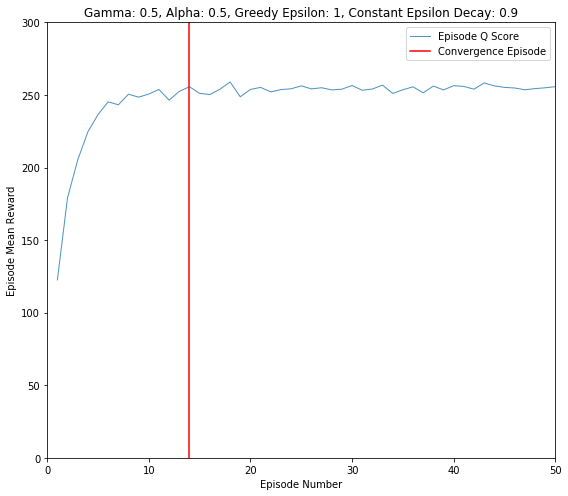

In [112]:
# Plot
plt.figure(figsize=(8,7))
x_episodes = np.linspace(1, max_episode_count, max_episode_count, endpoint=True)
conv_points_y = np.linspace(0, 400, 400, endpoint=True)
conv_points_x = [convergence_episode] * 400 

Q_line = plt.plot(x_episodes, episode_Q_store, alpha=0.8, linewidth=1, label = 'Episode Q Score')
conv_line = plt.plot(conv_points_x, conv_points_y, color='red', label = 'Convergence Episode')
plt.legend()
plt.title("Gamma: 0.5, Alpha: 0.5, Greedy Epsilon: 1, Constant Epsilon Decay: 0.9")
plt.ylim(0,300)
plt.xlim(0,50)
plt.xlabel('Episode Number')
plt.ylabel('Episode Mean Reward')

plt.tight_layout()
plt.show()    

<a id='3.-Grid-Search-Over-Epsilon-and-Decay-Factor'></a>

<a id='2.3-Test-Greedy-Modulated'></a>

### 2.2 Test Parameters using Modulated Decay Factor

In [113]:
# Initialise epsilon and epsilon decay rate (greedy_epsilon = greedy_epsilon - greedy_epsilon_rate)
greedy_epsilon = 1
greedy_epsilon_rate = 0.05

# Once the algorithm has converged (Q_mat_new == Q_mat_old), increase the greedy_epsilon_rate so 
# the algorithm exploits
greedy_epsilon_rate_exploit = 0.5

# Initialise alpha and gamma
alpha_learning_rate = 0.5
gamma_discount_factor = 1

# Initisalise convergence parameter, the number of episodes Q_mat_new and Q_mat_old stay the same
convergence_parameter = 15

# Initialise array to store episode rewards 
episode_Q_store = []

# Set maximum number of episodes to test
max_episode_count = 300

# Set number of trial samples to average
trial_samples = 50

#Reset variables
[Q_matrix_old, Q_matrix_new, start_location, current_state,
 algorithm_convergence, episode_convergence, episode] = funcVariablesReset()
convergence_episode = 0
convergence_episode_temp = 0
convergence_episode_store = []
reward_matrix_learning = [0]*reward_matrix
Q_matrix_new_sum_store = []
first = True

while episode <= max_episode_count-1:
#and np.sum(reward_matrix_learning) < len(reward_matrix): 
    
    episode_Q_value_trial_store = []
    
    for t in range(1, trial_samples+1):
        # Iterate through each episode (full journey from London to Lakes)
        episode_Q_value = funcEpisode(
            episode_convergence, current_state, Q_matrix_old, Q_matrix_new,
            greedy_epsilon, alpha_learning_rate, gamma_discount_factor)
        
        episode_Q_value_trial_store.append(episode_Q_value)
    
    episode_Q_value_mean = np.mean(episode_Q_value_trial_store)
    
    Q_matrix_new_sum_store.append(round(np.sum(Q_matrix_new),1))

    #Update the Q score for that episode
    episode_Q_store.append(episode_Q_value_mean)

    #Record max Q value
    episode_max_Q = max(episode_Q_store)

    # If still in exploration phase
    if convergence_episode == 0:
        # Reduce the greedy epsilon by greedy epsilon rate
        greedy_epsilon = greedy_epsilon * (1 - greedy_epsilon_rate)
    else:
        # Reduce the greedy epsilon by greedy epsilon rate
        greedy_epsilon = greedy_epsilon * (1 - greedy_epsilon_rate_exploit)

    # Prevent greedy epsilon from becoming negative
    if greedy_epsilon < 0:
        greedy_epsilon = 0
    
    # Check if all possible paths have been explored
    if np.count_nonzero(reward_matrix) == np.count_nonzero(Q_matrix_old): 

        # If so, check if the new Q matrix is equivalent to the previous episode's
        if np.array_equiv(np.round(Q_matrix_new, decimals=3), np.round(Q_matrix_old, decimals=3)):  
            convergence_episode_temp = episode
            convergence_episode_store.append(convergence_episode_temp)
        else:
            convergence_episode_store.append(0)
            #print('Conv_ep',episode,'Qmatnewsum',round(np.sum(Q_matrix_new),1))

    else:
        convergence_episode_store.append(0)
        #print('Conv_ep',episode,'Qmatnewsum',round(np.sum(Q_matrix_new),1))

    # Update Old Q matrix with new one for next iteration
    np.copyto(Q_matrix_old, Q_matrix_new)

    # Update the number of full journeys made
    episode +=1

    # If there have been more episodes than the convergence parameter
    if episode >= convergence_parameter:

        # Check if the value in the episode convergence store, convergence parameter positions previously is the same
        if Q_matrix_new_sum_store[episode-1] == Q_matrix_new_sum_store[episode-convergence_parameter]:

            # If the first time the previous condition has been met
            if first == True:
                # Update the convergence episode number
                convergence_episode = episode - convergence_parameter
                print('Algorithm converged in %d episodes' % convergence_episode)
                first = False
    else:
        convergence_episode = 0

Algorithm converged in 13 episodes


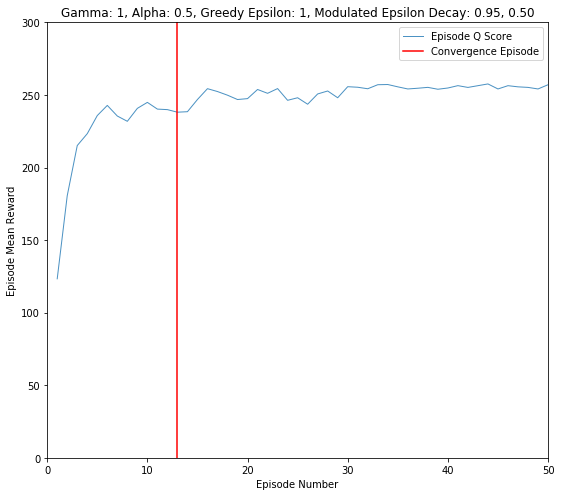

In [114]:
# Plot
plt.figure(figsize=(8,7))
x_episodes = np.linspace(1, max_episode_count, max_episode_count, endpoint=True)
conv_points_y = np.linspace(0, 400, 400, endpoint=True)
conv_points_x = [convergence_episode] * 400 

Q_line = plt.plot(x_episodes, episode_Q_store, alpha=0.8, linewidth=1, label = 'Episode Q Score')
conv_line = plt.plot(conv_points_x, conv_points_y, color='red', label = 'Convergence Episode')
plt.legend()
plt.title("Gamma: 1, Alpha: 0.5, Greedy Epsilon: 1, Modulated Epsilon Decay: 0.95, 0.50")
plt.ylim(0,300)
plt.xlim(0,50)
plt.xlabel('Episode Number')
plt.ylabel('Episode Mean Reward')

plt.tight_layout()
plt.show()

<a id='3.-Grid-Search-Over-Epsilon-and-Decay-Rate'></a>

## 3. Grid Search Over Epsilon and Constant Decay Factor

In [115]:
# Initialise epsilon and epsilon decay rate (if greedy epsilon is 1, then have a random policy)
alpha_learning_rate = 0.5
gamma_discount_factor = 0.5

# Set grid search range
epsilon_decay_range_size = 5
epsilon_decay_range = np.linspace(0, epsilon_decay_range_size, epsilon_decay_range_size)

min_exploration_factor = 0

# Initisalise convergence parameter
convergence_parameter = 15

# Initialise array to store grid search over alpha and gamma for number of episodes until convergence
np_algorithm_convergence_count = np.zeros(shape=(epsilon_decay_range_size**2, 3))

# Initialise array to store grid search over alpha and gamma for episode Q-scores until convergence
np_Q_scores_matrix = [[[] for j in range(epsilon_decay_range_size)] for i in range(epsilon_decay_range_size)]

# Initialise array to store number of episodes before convergence for each set of alpha and gamma
episode_count = []

# Set gamma counter, gamma store and alpha store
e = 0

# Set maximum number of episodes to test
max_episode_count = 300

#Start grid search
for greedy_epsilon_loop in epsilon_decay_range:
    
    # Set alpha counter
    d = 0
      
    for greedy_epsilon_rate_loop in epsilon_decay_range:
        greedy_epsilon_rate = greedy_epsilon_rate_loop/(epsilon_decay_range_size*10)
        greedy_epsilon = greedy_epsilon_loop/epsilon_decay_range_size
    
        #Reset variables
        [Q_matrix_old, Q_matrix_new, start_location, current_state,
         algorithm_convergence, episode_convergence, episode] = funcVariablesReset()
        convergence_episode = 0
        convergence_episode_store = []
        reward_matrix_learning = [0]*reward_matrix
        Q_matrix_new_sum_store = []
        first = True
        episode_Q_store = []

        print('TESTING: Epsilon', greedy_epsilon, 'Decay', (1-greedy_epsilon_rate))
        
        while episode <= max_episode_count-1: 
        #and np.sum(reward_matrix_learning) < len(reward_matrix): 
        
            #print('Epsilon', greedy_epsilon, 'Decay', greedy_epsilon_rate)

            episode_Q_value_trial_store = []
    
            for t in range(1, trial_samples+1):
                # Iterate through each episode (full journey from London to Lakes)
                episode_Q_value = funcEpisode(
                    episode_convergence, current_state, Q_matrix_old, Q_matrix_new,
                    greedy_epsilon, alpha_learning_rate, gamma_discount_factor)

                episode_Q_value_trial_store.append(episode_Q_value)

            episode_Q_value_mean = np.mean(episode_Q_value_trial_store)
            Q_matrix_new_sum_store.append(round(np.sum(Q_matrix_new),1))
            
            #Update the Q score for that episode
            episode_Q_store.append(episode_Q_value_mean)

            #Record max Q value
            episode_max_Q = max(episode_Q_store)
        
            # Reduce the greedy epsilon by greedy epsilon rate
            greedy_epsilon = greedy_epsilon*(1-greedy_epsilon_rate)
            
            # Prevent greedy epsilon from becoming negative
            if greedy_epsilon < 0:
                greedy_epsilon = 0
            
            # Check if all possible paths have been explored
            if np.count_nonzero(reward_matrix) == np.count_nonzero(Q_matrix_old): 

                # If so, check if the new Q matrix is equivalent to the previous episode's
                if np.array_equiv(np.round(Q_matrix_new, decimals=3), np.round(Q_matrix_old, decimals=3)):  
                    convergence_episode = episode
                    convergence_episode_store.append(convergence_episode)
                else:
                    convergence_episode_store.append(0)
                    #print('Conv_ep',episode,'Qmatnewsum',round(np.sum(Q_matrix_new),1))
                    
            else:
                convergence_episode_store.append(0)
                #print('Conv_ep',episode,'Qmatnewsum',round(np.sum(Q_matrix_new),1))
                
            # Update Old Q matrix with new one for next iteration
            np.copyto(Q_matrix_old, Q_matrix_new)
            
            # Update the number of full journeys made
            episode +=1
            
            # If there have been more episodes than the convergence parameter and the minimum exploration time
            if episode >= convergence_parameter and episode >= min_exploration_factor:
                
                # Check if the value in the episode convergence store, convergence parameter positions previously is the same
                if Q_matrix_new_sum_store[episode-1] == Q_matrix_new_sum_store[episode-convergence_parameter]:
                    
                    # If the first time the previous condition has been met
                    if first == True:
                        # Update the convergence episode number
                        convergence_episode = episode - convergence_parameter
                        print('Algorithm converged in %d episodes' % convergence_episode)
                        row = e * (epsilon_decay_range_size) + d
                        np_algorithm_convergence_count[row][2] = convergence_episode
                        first = False

            else:
                convergence_episode = 0
            
            #Store metrics for the set of hyperparameters
            row = e * (epsilon_decay_range_size) + d
            np_algorithm_convergence_count[row][0] = greedy_epsilon_rate_loop/(epsilon_decay_range_size*10)
            np_algorithm_convergence_count[row][1] = greedy_epsilon_loop/epsilon_decay_range_size
            np_Q_scores_matrix[d][e] = episode_Q_store  

        d+=1
    e+=1

TESTING: Epsilon 0.0 Decay 1.0
Algorithm converged in 42 episodes
TESTING: Epsilon 0.0 Decay 0.975
Algorithm converged in 33 episodes
TESTING: Epsilon 0.0 Decay 0.95
Algorithm converged in 32 episodes
TESTING: Epsilon 0.0 Decay 0.925
Algorithm converged in 37 episodes
TESTING: Epsilon 0.0 Decay 0.9
Algorithm converged in 34 episodes
TESTING: Epsilon 0.25 Decay 1.0
Algorithm converged in 17 episodes
TESTING: Epsilon 0.25 Decay 0.975
Algorithm converged in 17 episodes
TESTING: Epsilon 0.25 Decay 0.95
Algorithm converged in 15 episodes
TESTING: Epsilon 0.25 Decay 0.925
Algorithm converged in 19 episodes
TESTING: Epsilon 0.25 Decay 0.9
Algorithm converged in 23 episodes
TESTING: Epsilon 0.5 Decay 1.0
Algorithm converged in 14 episodes
TESTING: Epsilon 0.5 Decay 0.975
Algorithm converged in 15 episodes
TESTING: Epsilon 0.5 Decay 0.95
Algorithm converged in 26 episodes
TESTING: Epsilon 0.5 Decay 0.925
Algorithm converged in 14 episodes
TESTING: Epsilon 0.5 Decay 0.9
Algorithm converged in 35

<a id='3.1-Convergence-Rate'></a>

### 3.1 Inspect Effect on Convergence Rate

Text(60.0, 0.5, 'Decay Factor')

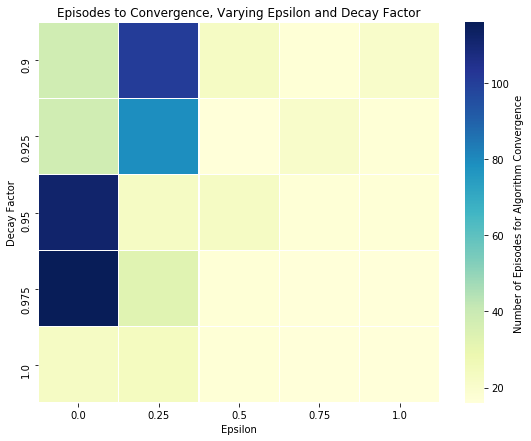

In [190]:
df_algorithm_convergence_count = pd.DataFrame(np_algorithm_convergence_count)
df_algorithm_convergence_count.columns=['Epsilon','Decay Rate','Episodes to Convergence']
df_algorithm_convergence_count
heatmap_epsilon_decay = df_algorithm_convergence_count.pivot('Epsilon', 'Decay Rate','Episodes to Convergence')

#heatmap_epsilon_decay.to_csv('heatmap_epsilon_decay_0.1_2.csv', index=False)
#heatmap_epsilon_decay = pd.read_csv('heatmap_epsilon_decay_0.1_2.csv')

plt.figure(figsize = (9,7))

ax = sns.heatmap(heatmap_epsilon_decay,
    linewidths=.5,
    vmax = max(np_algorithm_convergence_count[:,2]),
    cmap="YlGnBu",
    cbar_kws={'label': 'Number of Episodes for Algorithm Convergence'})

plt.title('Episodes to Convergence, Varying Epsilon and Decay Factor')
plt.xlabel('Epsilon')
plt.ylabel('Decay Factor')

<a id='3.2-Q-Scores'></a>

### 3.2 Inspect Effect on Q Scores

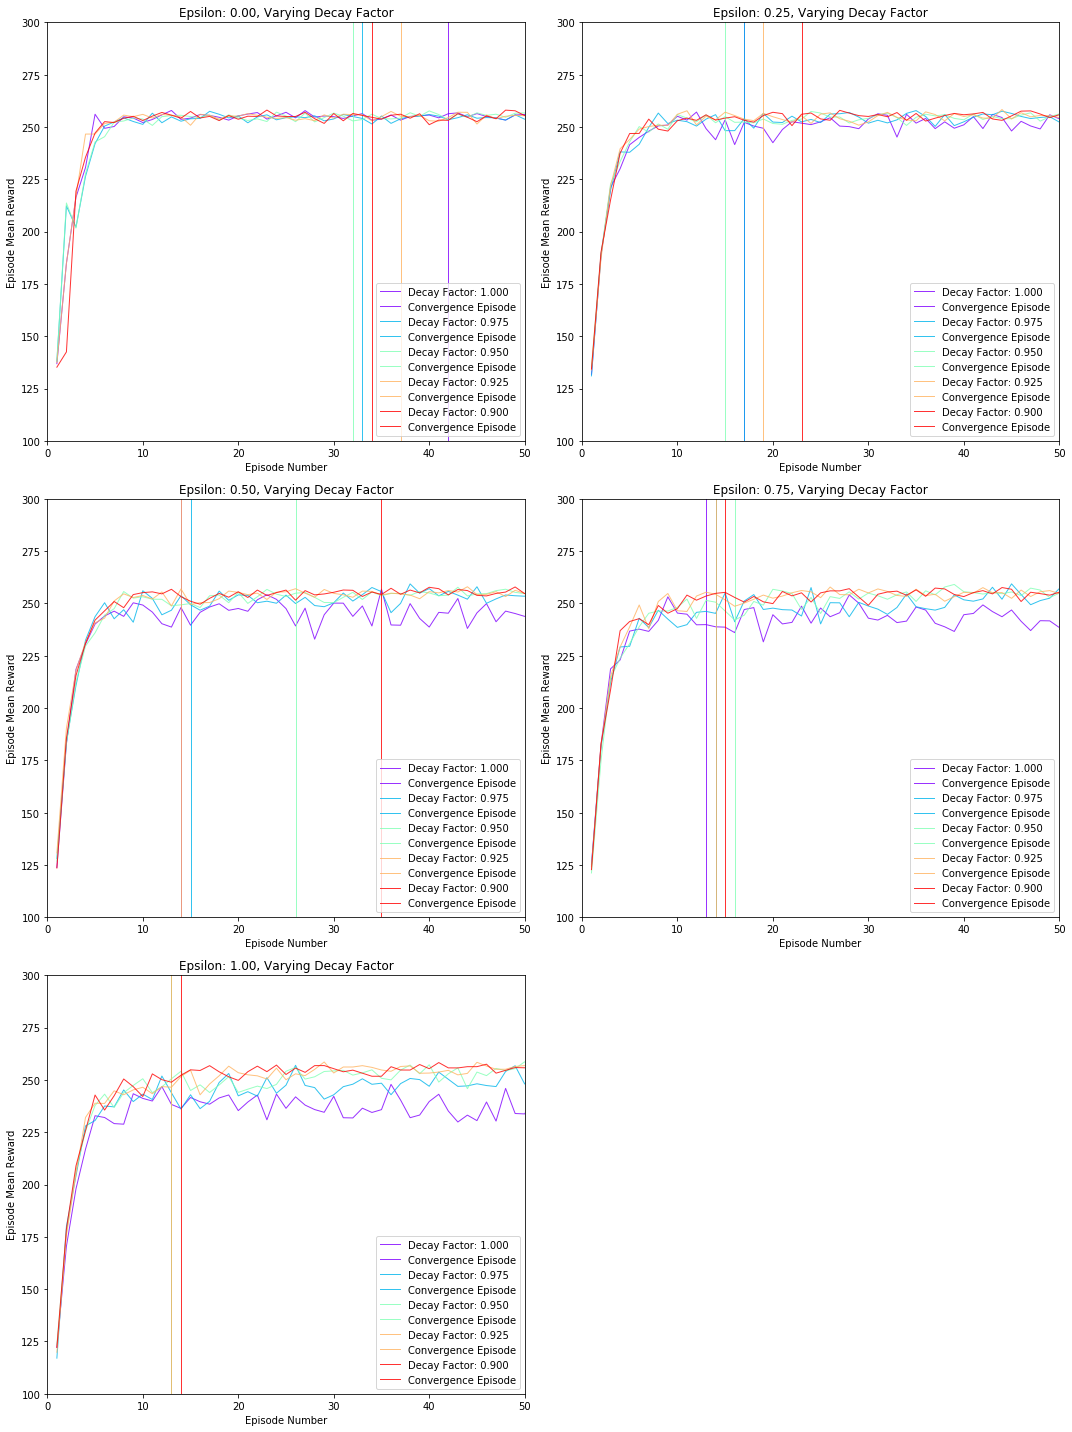

In [120]:
# Plot
fig = plt.figure(figsize=(15,20))

for e in range (0, len(np_Q_scores_matrix)):    
    
    ax = fig.add_subplot(len(np_Q_scores_matrix)/2+1,len(np_Q_scores_matrix)/2,e+1)   
    colour=iter(cm.rainbow(np.linspace(0,1,len(np_Q_scores_matrix))))
    
    for d in range (0, len(np_Q_scores_matrix)):
        c=next(colour)
        x_episodes = np.linspace(1, len(np_Q_scores_matrix[d][e]), len(np_Q_scores_matrix[d][e]), endpoint=True)
        row = e * (epsilon_decay_range_size) + d
        Q_line = ax.plot(x_episodes, np_Q_scores_matrix[d][e], alpha=0.8, c = c, linewidth=1, label = "Decay Factor: %0.3f" % (1-(epsilon_decay_range[d]/50)))
        plot_convergence_episode = int(np_algorithm_convergence_count[row][2])
        conv_points_y = np.linspace(0, 400, 400, endpoint=True)
        conv_points_x = [plot_convergence_episode] * 400 
        conv_line = ax.plot(conv_points_x, conv_points_y,label = 'Convergence Episode', c=c, linewidth=1, alpha = 0.8)
        ax.legend(loc=4)
        ax.set_title("Epsilon: %.2f, Varying Decay Factor" % float((epsilon_decay_range[e])/5))
        ax.set_ylim(100,300)
        ax.set_xlim(0,50)
        ax.set_xlabel('Episode Number')
        ax.set_ylabel('Episode Mean Reward')

plt.tight_layout()
plt.show()  

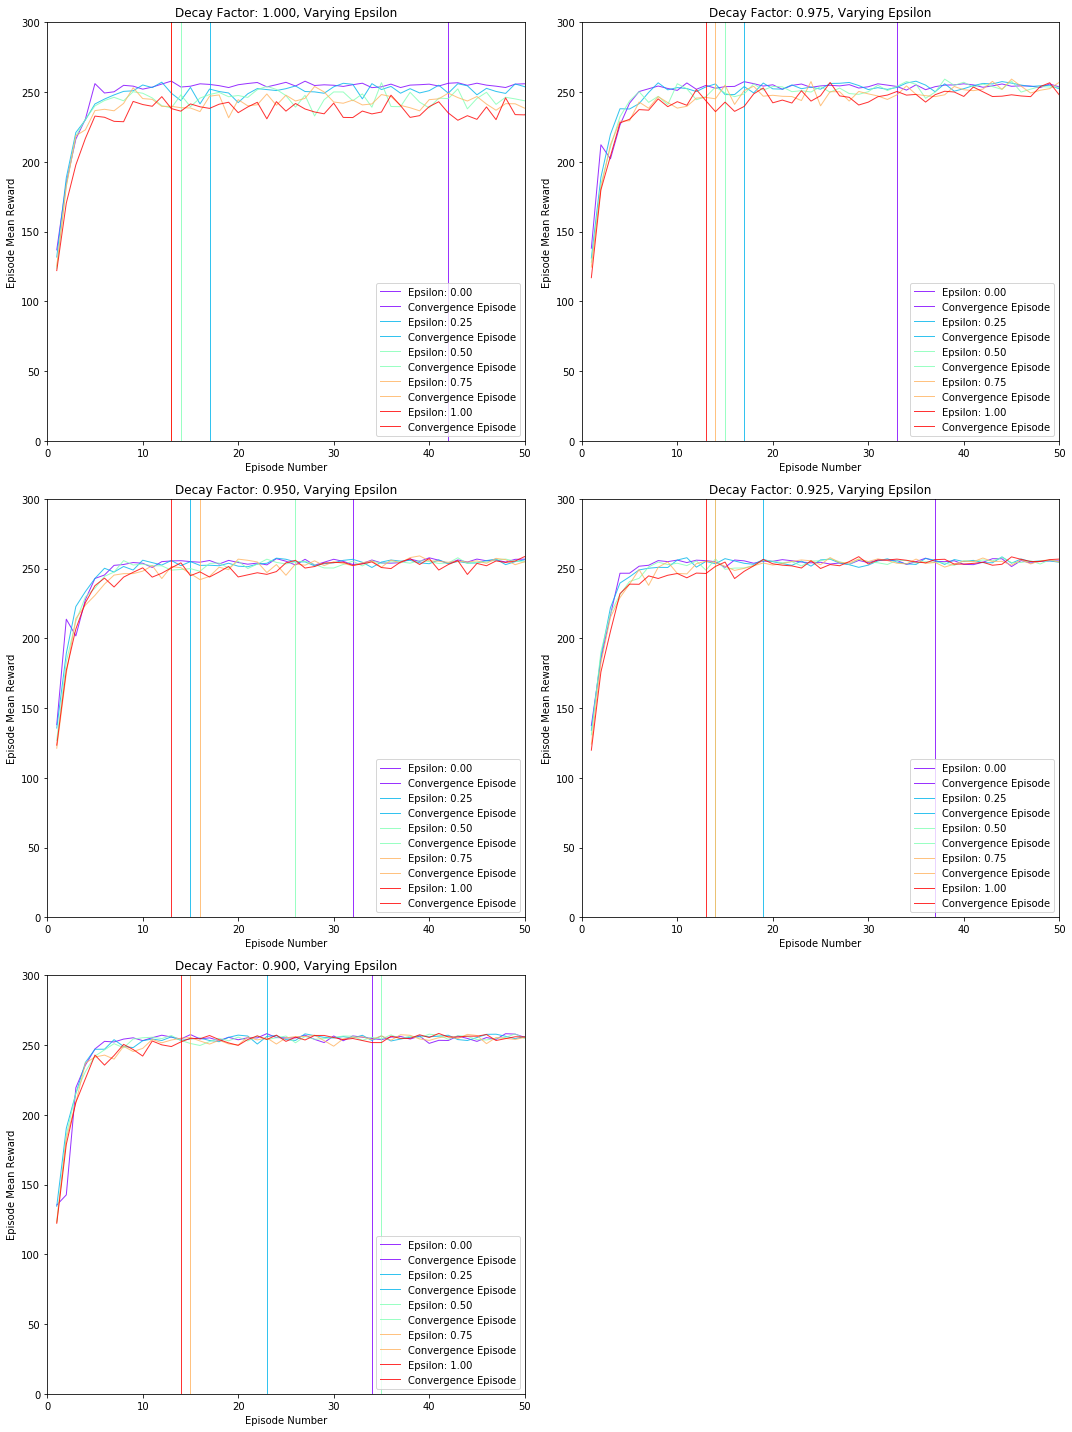

In [119]:
# Plot
fig = plt.figure(figsize=(15,20))

for d in range (0, len(np_Q_scores_matrix)):    
    
    ax = fig.add_subplot(len(np_Q_scores_matrix)/2+1,len(np_Q_scores_matrix)/2,d+1)   
    colour=iter(cm.rainbow(np.linspace(0,1,len(np_Q_scores_matrix))))
    
    for e in range (0, len(np_Q_scores_matrix)):
        c=next(colour)
        x_episodes = np.linspace(1, len(np_Q_scores_matrix[d][e]), len(np_Q_scores_matrix[d][e]), endpoint=True)
        row = e * (epsilon_decay_range_size) + d
        Q_line = ax.plot(x_episodes, np_Q_scores_matrix[d][e], alpha=0.8, c = c, linewidth=1, label = "Epsilon: %0.2f" % (epsilon_decay_range[e]/5))
        plot_convergence_episode = int(np_algorithm_convergence_count[row][2])
        conv_points_y = np.linspace(0, 400, 400, endpoint=True)
        conv_points_x = [plot_convergence_episode] * 400 
        conv_line = ax.plot(conv_points_x, conv_points_y,label = 'Convergence Episode', c=c, linewidth=1, alpha = 0.8)
        ax.legend(loc=4)
        ax.set_title("Decay Factor: %.3f, Varying Epsilon" % ((1-(epsilon_decay_range[d])/50)))
        ax.set_ylim(0,300)
        ax.set_xlim(0,50)
        ax.set_xlabel('Episode Number')
        ax.set_ylabel('Episode Mean Reward')

plt.tight_layout()
plt.show()   

<a id='4.-Grid-Search-Over-Alpha-and-Gamma'></a>

## 4. Grid Search Over Alpha With Constant Decay Factor

In [125]:
# Initialise epsilon and epsilon decay rate
greedy_epsilon = 0.5
greedy_epsilon_rate = 0.1
#greedy_epsilon_rate_exploit = 0.5

#min_exploration_factor = 15

# Initisalise convergence parameter
convergence_parameter = 15

# Set grid search range
alpha_gamma_range_size = 5
alpha_gamma_range = np.linspace(0, alpha_gamma_range_size, alpha_gamma_range_size)

# Initialise array to store grid search over alpha and gamma for number of episodes until convergence
np_algorithm_convergence_count = np.zeros(shape=(alpha_gamma_range_size**2, 3))

# Initialise array to store grid search over alpha and gamma for episode Q-scores until convergence
np_Q_scores_matrix = [[[] for j in range(alpha_gamma_range_size)] for i in range(alpha_gamma_range_size)]

# Initialise array to store number of episodes before convergence for each set of alpha and gamma
episode_count = []

# Set gamma counter, gamma store and alpha store
g = 0

# Set maximum number of episodes to test
max_episode_count = 300

#Start grid search
for gamma_discount_factor in alpha_gamma_range:
    gamma_discount_factor = gamma_discount_factor/5
    
    # Set alpha counter
    a = 0
      
    for alpha_learning_rate in alpha_gamma_range:
        alpha_learning_rate = alpha_learning_rate/5
    
        #Reset variables
        [Q_matrix_old, Q_matrix_new, start_location, current_state,
         algorithm_convergence, episode_convergence, episode] = funcVariablesReset()
        greedy_epsilon = 0.5
        convergence_episode = 0
        convergence_episode_store = []
        reward_matrix_learning = [0]*reward_matrix
        Q_matrix_new_sum_store = []
        first = True
        episode_Q_store = []

        print('TESTING: Gamma', gamma_discount_factor, 'Alpha', alpha_learning_rate)
        
        while episode <= max_episode_count-1: 
        #and np.sum(reward_matrix_learning) < len(reward_matrix): 

            episode_Q_value_trial_store = []
    
            for t in range(1, trial_samples+1):
                # Iterate through each episode (full journey from London to Lakes)
                episode_Q_value = funcEpisode(
                    episode_convergence, current_state, Q_matrix_old, Q_matrix_new,
                    greedy_epsilon, alpha_learning_rate, gamma_discount_factor)

                episode_Q_value_trial_store.append(episode_Q_value)

            episode_Q_value_mean = np.mean(episode_Q_value_trial_store)
            Q_matrix_new_sum_store.append(round(np.sum(Q_matrix_new),1))
            
            #Update the Q score for that episode
            episode_Q_store.append(episode_Q_value_mean)

            #Record max Q value
            episode_max_Q = max(episode_Q_store)
            
            # Reduce the greedy epsilon by greedy epsilon rate
            greedy_epsilon = greedy_epsilon*(1-greedy_epsilon_rate)
            
            # Prevent greedy epsilon from becoming negative
            if greedy_epsilon < 0:
                greedy_epsilon = 0
            
            # Check if all possible paths have been explored
            if np.count_nonzero(reward_matrix) == np.count_nonzero(Q_matrix_old): 

                # If so, check if the new Q matrix is equivalent to the previous episode's
                if np.array_equiv(np.round(Q_matrix_new, decimals=3), np.round(Q_matrix_old, decimals=3)):  
                    convergence_episode = episode
                    convergence_episode_store.append(convergence_episode)
                else:
                    convergence_episode_store.append(0)
                    #print('Conv_ep',episode,'Qmatnewsum',round(np.sum(Q_matrix_new),1))
                    
            else:
                convergence_episode_store.append(0)
                #print('Conv_ep',episode,'Qmatnewsum',round(np.sum(Q_matrix_new),1))
                
            # Update Old Q matrix with new one for next iteration
            np.copyto(Q_matrix_old, Q_matrix_new)
            
            # Update the number of full journeys made
            episode +=1
            
            # If there have been more episodes than the convergence parameter and the minimum exploration time
            if episode >= convergence_parameter and episode >= min_exploration_factor:
                
                # Check if the value in the episode convergence store, convergence parameter positions previously is the same
                if Q_matrix_new_sum_store[episode-1] == Q_matrix_new_sum_store[episode-convergence_parameter]:
                    
                    # If the first time the previous condition has been met
                    if first == True:
                        # Update the convergence episode number
                        convergence_episode = episode - convergence_parameter
                        print('Algorithm converged in %d episodes' % convergence_episode)
                        row = g * (alpha_gamma_range_size) + a
                        np_algorithm_convergence_count[row][2] = convergence_episode
                        first = False

            else:
                convergence_episode = 0
            
            #Store metrics for the set of hyperparameters
            row = g * (alpha_gamma_range_size) + a
            np_algorithm_convergence_count[row][0] = alpha_learning_rate
            np_algorithm_convergence_count[row][1] = gamma_discount_factor
            np_Q_scores_matrix[a][g] = episode_Q_store  

        a+=1
    g+=1

TESTING: Gamma 0.0 Alpha 0.0
Algorithm converged in 0 episodes
TESTING: Gamma 0.0 Alpha 0.25
Algorithm converged in 63 episodes
TESTING: Gamma 0.0 Alpha 0.5
Algorithm converged in 14 episodes
TESTING: Gamma 0.0 Alpha 0.75
Algorithm converged in 8 episodes
TESTING: Gamma 0.0 Alpha 1.0
Algorithm converged in 0 episodes
TESTING: Gamma 0.25 Alpha 0.0
Algorithm converged in 0 episodes
TESTING: Gamma 0.25 Alpha 0.25
Algorithm converged in 64 episodes
TESTING: Gamma 0.25 Alpha 0.5
Algorithm converged in 17 episodes
TESTING: Gamma 0.25 Alpha 0.75
Algorithm converged in 11 episodes
TESTING: Gamma 0.25 Alpha 1.0
Algorithm converged in 0 episodes
TESTING: Gamma 0.5 Alpha 0.0
Algorithm converged in 0 episodes
TESTING: Gamma 0.5 Alpha 0.25
Algorithm converged in 43 episodes
TESTING: Gamma 0.5 Alpha 0.5
Algorithm converged in 13 episodes
TESTING: Gamma 0.5 Alpha 0.75
Algorithm converged in 18 episodes
TESTING: Gamma 0.5 Alpha 1.0
Algorithm converged in 0 episodes
TESTING: Gamma 0.75 Alpha 0.0
Algori

<a id='3.1-Convergence-Rate'></a>

<a id='4.1-Convergence-Rate'></a>

### 4.1 Inspect Effect on Convergence Rate

Text(60.0, 0.5, 'Alpha')

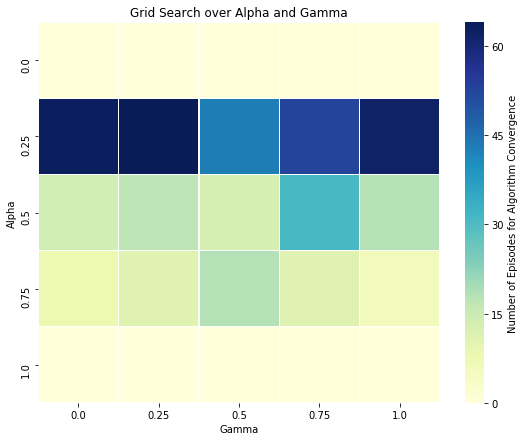

In [131]:
df_algorithm_convergence_count = pd.DataFrame(np_algorithm_convergence_count)
df_algorithm_convergence_count.columns=['Alpha','Gamma','Episodes to Convergence']
df_algorithm_convergence_count
heatmap_alpha_gamma = df_algorithm_convergence_count.pivot('Alpha', 'Gamma','Episodes to Convergence')

#heatmap_alpha_gamma.to_csv('heatmap_alpha_gamma_0.1_2.csv', index=False)
#heatmap_alpha_gamma = pd.read_csv('heatmap_alpha_gamma_0.1_2.csv')

plt.figure(figsize = (9,7))

ax = sns.heatmap(heatmap_alpha_gamma,
    linewidths=.5,
    vmax = max(np_algorithm_convergence_count[:,2]),
    cmap="YlGnBu",
    cbar_kws={'label': 'Number of Episodes for Algorithm Convergence'})

plt.title('Grid Search over Alpha and Gamma')
plt.xlabel('Gamma')
plt.ylabel('Alpha')

<a id='3.2-Q-Scores'></a>

<a id='4.2-Q-Scores'></a>

### 4.2 Inspect Effect on Evolution of Episode Q-Scores

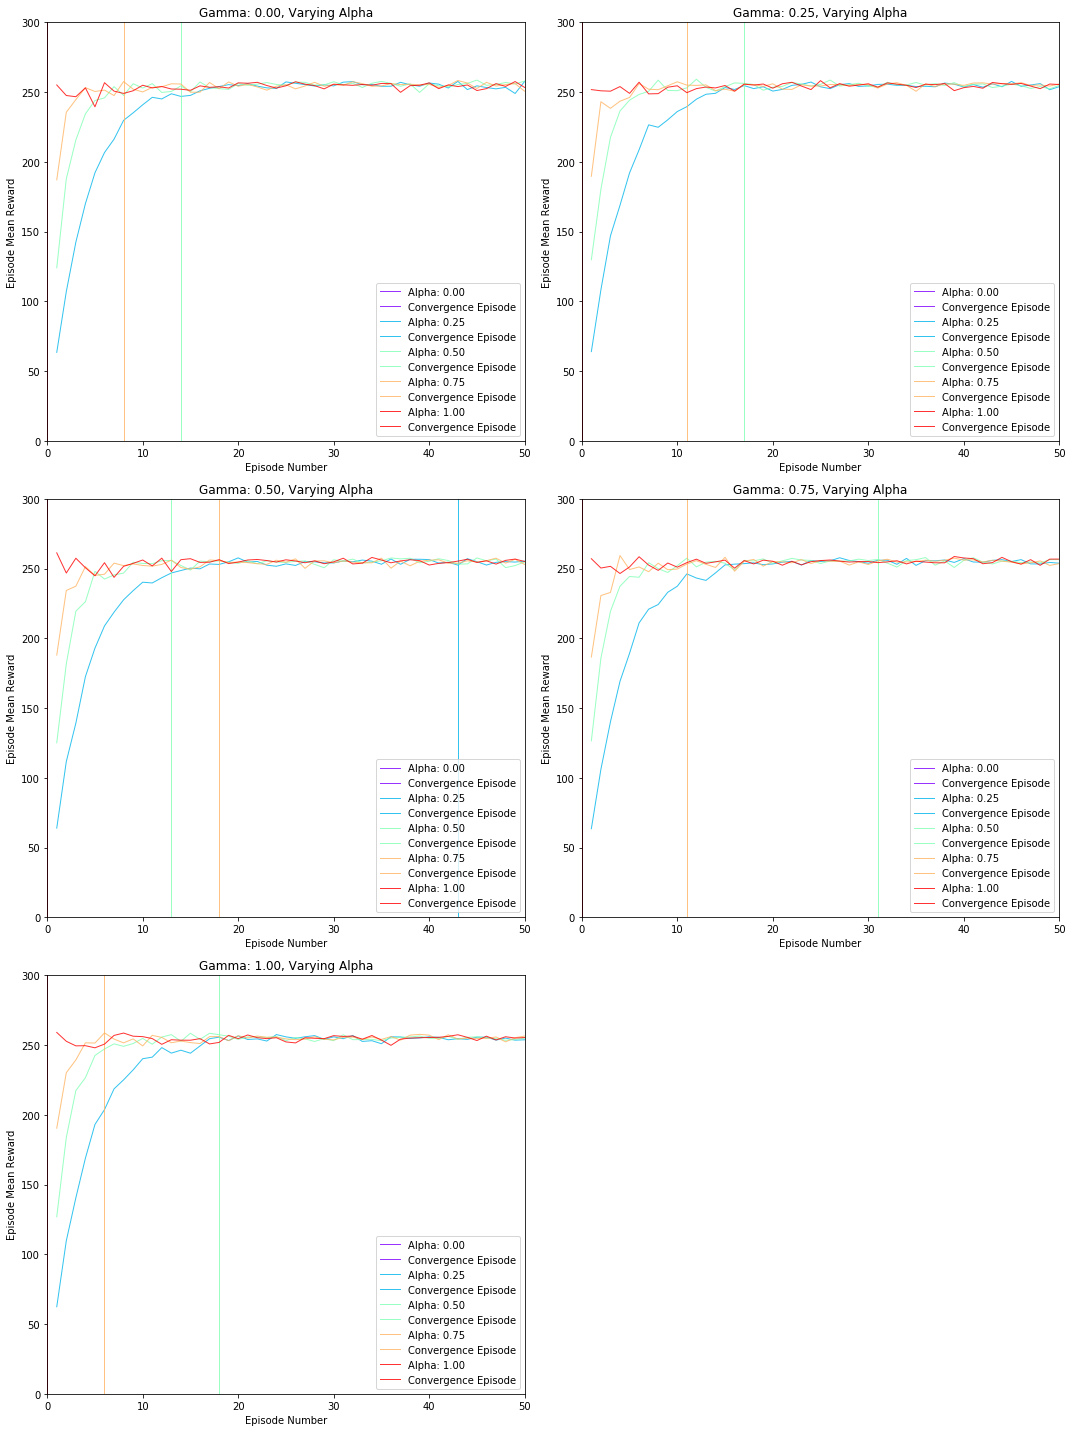

In [133]:
# Plot
fig = plt.figure(figsize=(15,20))

for g in range (0, len(np_Q_scores_matrix)):    
    
    ax = fig.add_subplot(len(np_Q_scores_matrix)/2+1,len(np_Q_scores_matrix)/2,g+1)   
    colour=iter(cm.rainbow(np.linspace(0,1,len(np_Q_scores_matrix))))
    
    for a in range (0, len(np_Q_scores_matrix)):
        c=next(colour)
        x_episodes = np.linspace(1, len(np_Q_scores_matrix[a][g]), len(np_Q_scores_matrix[a][g]), endpoint=True)
        row = g * (alpha_gamma_range_size) + a
        Q_line = ax.plot(x_episodes, np_Q_scores_matrix[a][g], alpha=0.8, c = c, linewidth=1, label = "Alpha: %0.2f" % (alpha_gamma_range[a]/5))
        plot_convergence_episode = int(np_algorithm_convergence_count[row][2])
        conv_points_y = np.linspace(0, 400, 400, endpoint=True)
        conv_points_x = [plot_convergence_episode] * 400 
        conv_line = ax.plot(conv_points_x, conv_points_y,label = 'Convergence Episode', c=c, linewidth=1, alpha = 0.8)
        ax.legend(loc=4)
        ax.set_title("Gamma: %0.2f, Varying Alpha" % (alpha_gamma_range[g]/5))
        ax.set_ylim(0,300)
        ax.set_xlim(0,50)
        ax.set_xlabel('Episode Number')
        ax.set_ylabel('Episode Mean Reward')

plt.tight_layout()
plt.show()    

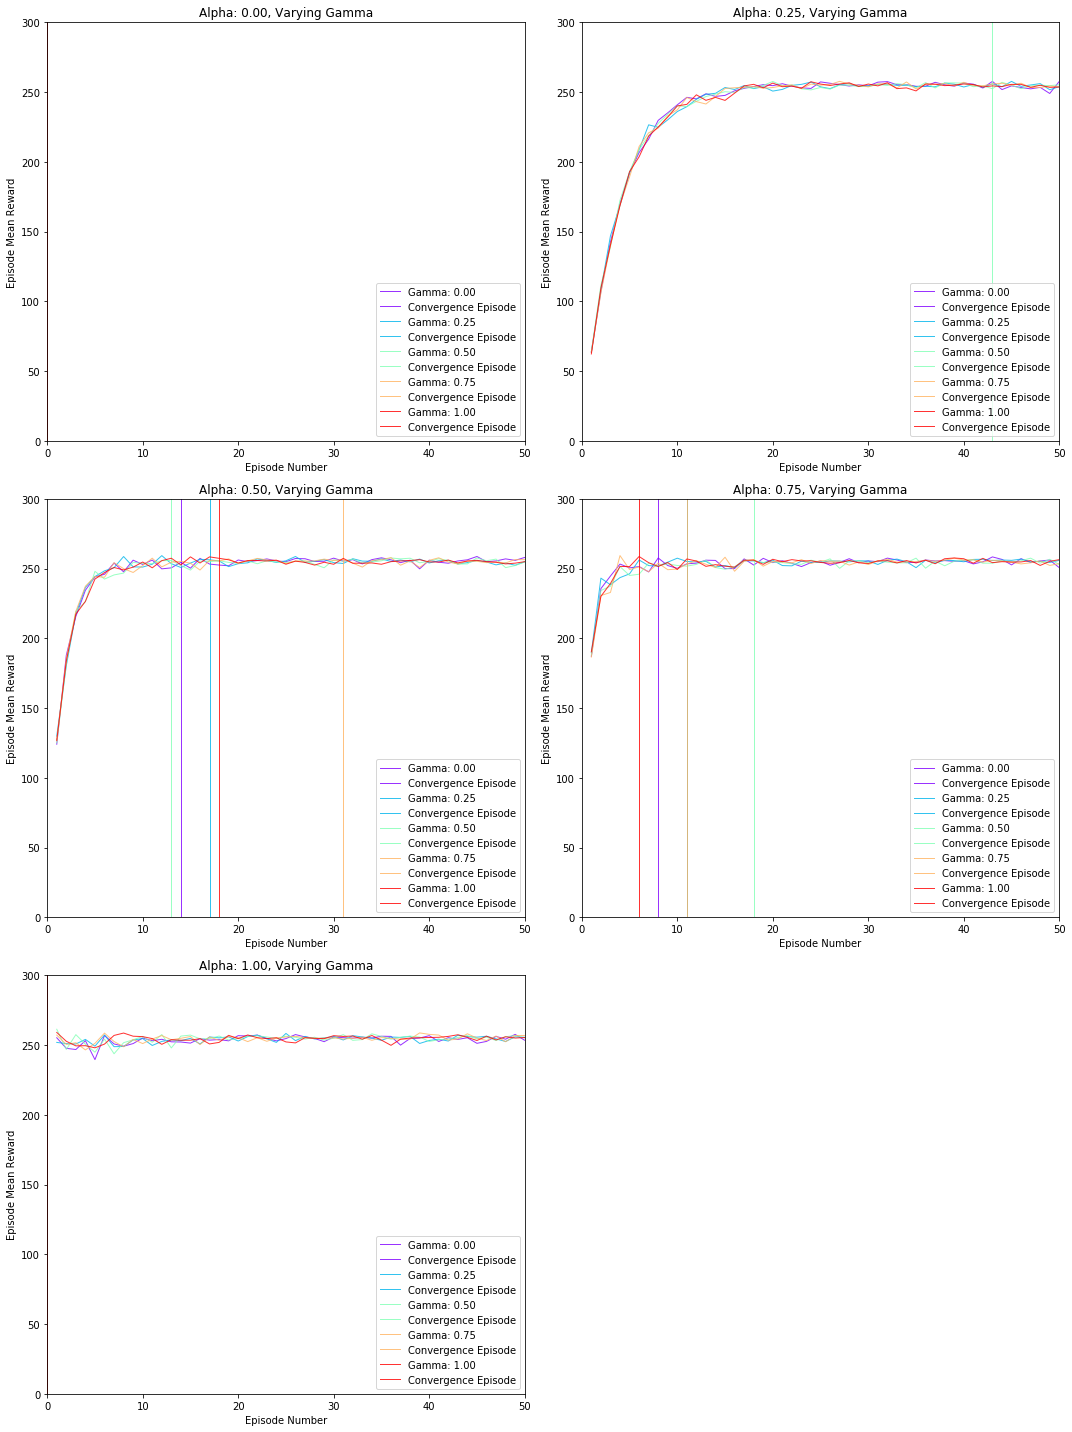

In [134]:
# Plot
fig = plt.figure(figsize=(15,20))

for a in range (0, len(np_Q_scores_matrix)):    
    
    ax = fig.add_subplot(len(np_Q_scores_matrix)/2+1,len(np_Q_scores_matrix)/2,a+1)   
    colour=iter(cm.rainbow(np.linspace(0,1,len(np_Q_scores_matrix))))
    
    for g in range (0, len(np_Q_scores_matrix)):
        c=next(colour)
        x_episodes = np.linspace(1, len(np_Q_scores_matrix[a][g]), len(np_Q_scores_matrix[a][g]), endpoint=True)
        row = g * (alpha_gamma_range_size) + a
        Q_line = ax.plot(x_episodes, np_Q_scores_matrix[a][g], alpha=0.8, c = c, linewidth=1, label = "Gamma: %0.2f" % (alpha_gamma_range[g]/5))
        plot_convergence_episode = int(np_algorithm_convergence_count[row][2])
        conv_points_y = np.linspace(0, 400, 400, endpoint=True)
        conv_points_x = [plot_convergence_episode] * 400 
        conv_line = ax.plot(conv_points_x, conv_points_y,label = 'Convergence Episode', c=c, linewidth=1, alpha = 0.8)
        ax.legend(loc=4)
        ax.set_title("Alpha: %0.2f, Varying Gamma" % (alpha_gamma_range[a]/5))
        ax.set_ylim(0,300)
        ax.set_xlim(0,50)
        ax.set_xlabel('Episode Number')
        ax.set_ylabel('Episode Mean Reward')

plt.tight_layout()
plt.show()    

<a id='5.-Modify-Reward'></a>

## 5. Modifying the Reward Matrix

<a id='5.1-Optimise-Cost'></a>

### 5.1 Optimise for Lowest Cost

In [ ]:
# Read the base matrix csv which contains all the meta data for each possible journey
base_matrix_url = "https://raw.githubusercontent.com/Stephanie-Jury/Software-Agents/master/base_matrix.csv"
df_base_matrix = pd.read_csv(base_matrix_url)
df_base_matrix['Reward Score'] = 0

# Set importance of each factor for the reward function
weight_duration = 0  # Set weight of journey duration term
weight_train_change = 1  # Set weight of changing train term
weight_cost = 1  # Set weight of journey cost term

for i in range(0, len(df_base_matrix)):

    # Select journey characteristics
    duration = df_base_matrix['Duration'][i]
    train_change = df_base_matrix['Platform Change'][i]
    cost = df_base_matrix['Cost'][i]

    # Calculate total reward for journey (weighted sum of rewards from train change, journey cost and duration)

    # 1. Calculate reward for journey duration
    if (duration == 0):
        reward_duration = 0
    elif (0 < duration <= 60):
        reward_duration = 15
    elif (60 < duration <= 120):
        reward_duration = 10
    elif (120 < duration <= 180):
        reward_duration = 5
    elif (180 < duration <= 240):
        reward_duration = 1
    else:
        reward_duration = -1

    # 2. Calculate reward (penalty) for each change
    if (train_change == 1):
        reward_train_change = -10
    else:
        reward_train_change = 0

    # 3. Calculate reward for the cost of the journey
    if (cost == 0):
        reward_cost = 0
    elif (0 < cost <= 10):
        reward_cost = 15
    elif (10 < cost <= 30):
        reward_cost = 14
    elif (30 < cost <= 40):
        reward_cost = 13
    elif (40 < cost <= 60):
        reward_cost = 12
    elif (60 < cost <= 80):
        reward_cost = 10
    elif (80 < cost <= 90):
        reward_cost = 7
    elif (90 < cost <= 100):
        reward_cost = 4
    elif (100 < cost <= 110):
        reward_cost = 1
    else:
        reward_cost = -1

    # Combine total reward
    reward = weight_duration*reward_duration + weight_train_change * \
        reward_train_change + weight_cost*reward_cost

    # Update the base matrix with the reward
    df_base_matrix['Reward Score'][i] = reward

# Use reward scores to generate a final 8 x 8 reward matrix of all possible journey options
np_reward_matrix = np.zeros(shape=(10, 10))

for i in range(0, len(df_base_matrix)):
    s = int(df_base_matrix['SourceID'][i])
    t = int(df_base_matrix['TargetID'][i])
    np_reward_matrix[s, t] = df_base_matrix['Reward Score'][i]

reward_matrix = np_reward_matrix

# Add additional rewards for nearing goal state
reward_matrix[7, 9] = reward_matrix[7, 9] + 150
reward_matrix[8, 9] = reward_matrix[8, 9] + 150

# Add additional reward +10 for reaching one step before goal state
reward_matrix[0, 7] = reward_matrix[0, 7] + 10
reward_matrix[0, 8] = reward_matrix[0, 8] + 10
reward_matrix[6, 7] = reward_matrix[6, 7] + 10
reward_matrix[7, 8] = reward_matrix[7, 8] + 10

# (Visualise as dataframe)
df_reward_matrix = pd.DataFrame(np_reward_matrix)
df_reward_matrix.columns = [
    'London', 'Banbury', 'Birmingham Moor Street', 'Birmingham New Street',
    'Reading', 'Sheffield', 'Manchester Piccadilly', 'Preston', 'Oxenholme',
    'Lakes'
]

df_reward_matrix.rename(
    index={
        0: 'London',
        1: 'Banbury',
        2: 'Birmingham Moor Street',
        3: 'Birmingham New Street',
        4: 'Reading',
        5: 'Sheffield',
        6: 'Manchester Piccadilly',
        7: 'Preston',
        8: 'Oxenholme',
        9: 'Lakes',
    },
    inplace=True)
df_reward_matrix

<a id='4.2-Optimise-Duration'></a>

In [ ]:
# Initialise epsilon and epsilon decay rate (greedy_epsilon = greedy_epsilon - greedy_epsilon_rate)
greedy_epsilon = 1
greedy_epsilon_rate = 0.025

# Initialise alpha and gamma
alpha_learning_rate = 0.5
gamma_discount_factor = 0.5

# Initisalise convergence parameter, the number of episodes Q_mat_new and Q_mat_old stay the same
convergence_parameter = 15

# Initialise array to store episode rewards 
episode_Q_store = []

# Set maximum number of episodes to test
max_episode_count = 300

# Set number of trial samples to average
trial_samples = 50

#Reset variables
[Q_matrix_old, Q_matrix_new, start_location, current_state,
 algorithm_convergence, episode_convergence, episode] = funcVariablesReset()
convergence_episode = 0
convergence_episode_temp = 0
convergence_episode_store = []
reward_matrix_learning = [0]*reward_matrix
Q_matrix_new_sum_store = []
first = True

while episode <= max_episode_count-1:
#and np.sum(reward_matrix_learning) < len(reward_matrix): 
    
    episode_Q_value_trial_store = []
    
    for t in range(1, trial_samples+1):
        # Iterate through each episode (full journey from London to Lakes)
        episode_Q_value = funcEpisode(
            episode_convergence, current_state, Q_matrix_old, Q_matrix_new,
            greedy_epsilon, alpha_learning_rate, gamma_discount_factor)
        
        episode_Q_value_trial_store.append(episode_Q_value)
    
    episode_Q_value_mean = np.mean(episode_Q_value_trial_store)
    
    Q_matrix_new_sum_store.append(round(np.sum(Q_matrix_new),1))

    #Update the Q score for that episode
    episode_Q_store.append(episode_Q_value_mean)

    #Record max Q value
    episode_max_Q = max(episode_Q_store)

    # After every 4 episodes, reduce the greedy epsilon by greedy epsilon rate
    greedy_epsilon = greedy_epsilon * (1 - greedy_epsilon_rate)

    # Prevent greedy epsilon from becoming negative
    if greedy_epsilon < 0:
        greedy_epsilon = 0
    
    # Check if all possible paths have been explored
    if np.count_nonzero(reward_matrix) == np.count_nonzero(Q_matrix_old): 

        # If so, check if the new Q matrix is equivalent to the previous episode's
        if np.array_equiv(np.round(Q_matrix_new, decimals=3), np.round(Q_matrix_old, decimals=3)):  
            convergence_episode_temp = episode
            convergence_episode_store.append(convergence_episode_temp)
        else:
            convergence_episode_store.append(0)
            #print('Conv_ep',episode,'Qmatnewsum',round(np.sum(Q_matrix_new),1))

    else:
        convergence_episode_store.append(0)
        #print('Conv_ep',episode,'Qmatnewsum',round(np.sum(Q_matrix_new),1))

    # Update Old Q matrix with new one for next iteration
    np.copyto(Q_matrix_old, Q_matrix_new)

    # Update the number of full journeys made
    episode +=1

    # If there have been more episodes than the convergence parameter
    if episode >= convergence_parameter:

        # Check if the value in the episode convergence store, convergence parameter positions previously is the same
        if Q_matrix_new_sum_store[episode-1] == Q_matrix_new_sum_store[episode-convergence_parameter]:

            # If the first time the previous condition has been met
            if first == True:
                # Update the convergence episode number
                convergence_episode = episode - convergence_parameter
                print('Algorithm converged in %d episodes' % convergence_episode)
                first = False
    else:
        convergence_episode = 0  

In [ ]:
# Plot
plt.figure(figsize=(15,7))
x_episodes = np.linspace(1, max_episode_count, max_episode_count, endpoint=True)
conv_points_y = np.linspace(0, 400, 400, endpoint=True)
conv_points_x = [convergence_episode] * 400 

Q_line = plt.plot(x_episodes, episode_Q_store, alpha=0.8, linewidth=1, label = 'Episode Q Score')
conv_line = plt.plot(conv_points_x, conv_points_y, color='red', label = 'Convergence Episode')
plt.legend()
plt.title("Alpha: 0.5, Gamma: 0.5, Greedy Epsilon: 1, Decay Factor: 0.025")
plt.ylim(0,300)
plt.xlim(0,50)
plt.xlabel('Episode Number')
plt.ylabel('Episode Mean Reward')

plt.tight_layout()
plt.show()   

<a id='5.2-Optimise-Duration'></a>

### 5.2 Optimise for Shortest Duration

In [ ]:
# Read the base matrix csv which contains all the meta data for each possible journey
base_matrix_url = "https://raw.githubusercontent.com/Stephanie-Jury/Software-Agents/master/base_matrix.csv"
df_base_matrix = pd.read_csv(base_matrix_url)
df_base_matrix['Reward Score'] = 0

# Set importance of each factor for the reward function
weight_duration = 1  # Set weight of journey duration term
weight_train_change = 1  # Set weight of changing train term
weight_cost = 0  # Set weight of journey cost term

for i in range(0, len(df_base_matrix)):

    # Select journey characteristics
    duration = df_base_matrix['Duration'][i]
    train_change = df_base_matrix['Platform Change'][i]
    cost = df_base_matrix['Cost'][i]

    # Calculate total reward for journey (weighted sum of rewards from train change, journey cost and duration)

    # 1. Calculate reward for journey duration
    if (duration == 0):
        reward_duration = 0
    elif (0 < duration <= 60):
        reward_duration = 15
    elif (60 < duration <= 120):
        reward_duration = 10
    elif (120 < duration <= 180):
        reward_duration = 5
    elif (180 < duration <= 240):
        reward_duration = 1
    else:
        reward_duration = -1

    # 2. Calculate reward (penalty) for each change
    if (train_change == 1):
        reward_train_change = -10
    else:
        reward_train_change = 0

    # 3. Calculate reward for the cost of the journey
    if (cost == 0):
        reward_cost = 0
    elif (0 < cost <= 10):
        reward_cost = 15
    elif (10 < cost <= 30):
        reward_cost = 14
    elif (30 < cost <= 40):
        reward_cost = 13
    elif (40 < cost <= 60):
        reward_cost = 12
    elif (60 < cost <= 80):
        reward_cost = 10
    elif (80 < cost <= 90):
        reward_cost = 7
    elif (90 < cost <= 100):
        reward_cost = 4
    elif (100 < cost <= 110):
        reward_cost = 1
    else:
        reward_cost = -1

    # Combine total reward
    reward = weight_duration*reward_duration + weight_train_change * \
        reward_train_change + weight_cost*reward_cost

    # Update the base matrix with the reward
    df_base_matrix['Reward Score'][i] = reward

# Use reward scores to generate a final 8 x 8 reward matrix of all possible journey options
np_reward_matrix = np.zeros(shape=(10, 10))

for i in range(0, len(df_base_matrix)):
    s = int(df_base_matrix['SourceID'][i])
    t = int(df_base_matrix['TargetID'][i])
    np_reward_matrix[s, t] = df_base_matrix['Reward Score'][i]

reward_matrix = np_reward_matrix

# Add additional rewards for nearing goal state
reward_matrix[7, 9] = reward_matrix[7, 9] + 150
reward_matrix[8, 9] = reward_matrix[8, 9] + 150

# Add additional reward +10 for reaching one step before goal state
reward_matrix[0, 7] = reward_matrix[0, 7] + 10
reward_matrix[0, 8] = reward_matrix[0, 8] + 10
reward_matrix[6, 7] = reward_matrix[6, 7] + 10
reward_matrix[7, 8] = reward_matrix[7, 8] + 10

# (Visualise as dataframe)
df_reward_matrix = pd.DataFrame(np_reward_matrix)
df_reward_matrix.columns = [
    'London', 'Banbury', 'Birmingham Moor Street', 'Birmingham New Street',
    'Reading', 'Sheffield', 'Manchester Piccadilly', 'Preston', 'Oxenholme',
    'Lakes'
]

df_reward_matrix.rename(
    index={
        0: 'London',
        1: 'Banbury',
        2: 'Birmingham Moor Street',
        3: 'Birmingham New Street',
        4: 'Reading',
        5: 'Sheffield',
        6: 'Manchester Piccadilly',
        7: 'Preston',
        8: 'Oxenholme',
        9: 'Lakes',
    },
    inplace=True)
df_reward_matrix

In [ ]:
# Initialise epsilon and epsilon decay rate (greedy_epsilon = greedy_epsilon - greedy_epsilon_rate)
greedy_epsilon = 1
greedy_epsilon_rate = 0.025

# Initialise alpha and gamma
alpha_learning_rate = 0.5
gamma_discount_factor = 0.5

# Initisalise convergence parameter, the number of episodes Q_mat_new and Q_mat_old stay the same
convergence_parameter = 15

# Initialise array to store episode rewards 
episode_Q_store = []

# Set maximum number of episodes to test
max_episode_count = 300

# Set number of trial samples to average
trial_samples = 50

#Reset variables
[Q_matrix_old, Q_matrix_new, start_location, current_state,
 algorithm_convergence, episode_convergence, episode] = funcVariablesReset()
convergence_episode = 0
convergence_episode_temp = 0
convergence_episode_store = []
reward_matrix_learning = [0]*reward_matrix
Q_matrix_new_sum_store = []
first = True

while episode <= max_episode_count-1:
#and np.sum(reward_matrix_learning) < len(reward_matrix): 
    
    episode_Q_value_trial_store = []
    
    for t in range(1, trial_samples+1):
        # Iterate through each episode (full journey from London to Lakes)
        episode_Q_value = funcEpisode(
            episode_convergence, current_state, Q_matrix_old, Q_matrix_new,
            greedy_epsilon, alpha_learning_rate, gamma_discount_factor)
        
        episode_Q_value_trial_store.append(episode_Q_value)
    
    episode_Q_value_mean = np.mean(episode_Q_value_trial_store)
    
    Q_matrix_new_sum_store.append(round(np.sum(Q_matrix_new),1))

    #Update the Q score for that episode
    episode_Q_store.append(episode_Q_value_mean)

    #Record max Q value
    episode_max_Q = max(episode_Q_store)

    # Reduce the greedy epsilon by greedy epsilon rate
    greedy_epsilon = greedy_epsilon * (1 - greedy_epsilon_rate)

    # Prevent greedy epsilon from becoming negative
    if greedy_epsilon < 0:
        greedy_epsilon = 0
    
    # Check if all possible paths have been explored
    if np.count_nonzero(reward_matrix) == np.count_nonzero(Q_matrix_old): 

        # If so, check if the new Q matrix is equivalent to the previous episode's
        if np.array_equiv(np.round(Q_matrix_new, decimals=3), np.round(Q_matrix_old, decimals=3)):  
            convergence_episode_temp = episode
            convergence_episode_store.append(convergence_episode_temp)
        else:
            convergence_episode_store.append(0)
            #print('Conv_ep',episode,'Qmatnewsum',round(np.sum(Q_matrix_new),1))

    else:
        convergence_episode_store.append(0)
        #print('Conv_ep',episode,'Qmatnewsum',round(np.sum(Q_matrix_new),1))

    # Update Old Q matrix with new one for next iteration
    np.copyto(Q_matrix_old, Q_matrix_new)

    # Update the number of full journeys made
    episode +=1

    # If there have been more episodes than the convergence parameter
    if episode >= convergence_parameter:

        # Check if the value in the episode convergence store, convergence parameter positions previously is the same
        if Q_matrix_new_sum_store[episode-1] == Q_matrix_new_sum_store[episode-convergence_parameter]:

            # If the first time the previous condition has been met
            if first == True:
                # Update the convergence episode number
                convergence_episode = episode - convergence_parameter
                print('Algorithm converged in %d episodes' % convergence_episode)
                first = False
    else:
        convergence_episode = 0 

In [ ]:
# Plot
plt.figure(figsize=(15,7))
x_episodes = np.linspace(1, max_episode_count, max_episode_count, endpoint=True)
conv_points_y = np.linspace(0, 400, 400, endpoint=True)
conv_points_x = [convergence_episode] * 400 

Q_line = plt.plot(x_episodes, episode_Q_store, alpha=0.8, linewidth=1, label = 'Episode Q Score')
conv_line = plt.plot(conv_points_x, conv_points_y, color='red', label = 'Convergence Episode')
plt.legend()
plt.title("Alpha: 0.5, Gamma: 0.5, Greedy Epsilon: 1, Decay Factor: 0.025")
plt.ylim(0,300)
plt.xlim(0,50)
plt.xlabel('Episode Number')
plt.ylabel('Episode Mean Reward')

plt.tight_layout()
plt.show()  

<a id='6.-Modify-States'></a>

## 6. Modifying the Problem Space

In [149]:
# Read the base matrix csv which contains all the meta data for each possible journey
base_matrix_return_url = "https://raw.githubusercontent.com/Stephanie-Jury/Software-Agents/master/base_matrix_return.csv"
df_base_matrix = pd.read_csv(base_matrix_return_url)
df_base_matrix

,Source,Target,SourceID,TargetID,Duration,Cost,Platform Change
0,London,Birmingham Moor Street,0,2,204,20.00,1
1,London,Banbury,0,1,118,18.90,1
2,London,Reading,0,4,28,27.40,1
3,London,Sheffield,0,5,134,56.50,1
4,London,Preston,0,7,202,94.40,1
5,London,Oxenholme,0,8,102,105.20,1
6,Banbury,Birmingham New Street,1,3,86,12.86,1
7,Banbury,Reading,1,4,44,12.50,1
8,Birmingham Moor Street,Birmingham New Street,2,3,14,6.11,1
9,Birmingham New Street,Manchester Piccadilly,3,6,78,18.52,1


In [155]:
# Start by adding a reward column to the base matrix
df_base_matrix['Reward Score'] = 0

# Set importance of each factor for the reward function
weight_duration = 1  # Set weight of journey duration term
weight_train_change = 1  # Set weight of changing train term
weight_cost = 1  # Set weight of journey cost term

for i in range(0, 17):

    # Select journey characteristics
    duration = df_base_matrix['Duration'][i]
    train_change = df_base_matrix['Platform Change'][i]
    cost = df_base_matrix['Cost'][i]

    # Calculate total reward for journey (weighted sum of rewards from train change, journey cost and duration)

    # 1. Calculate reward for journey duration
    if (duration == 0):
        reward_duration = 0
    elif (0 < duration <= 60):
        reward_duration = 15
    elif (60 < duration <= 120):
        reward_duration = 10
    elif (120 < duration <= 180):
        reward_duration = 5
    elif (180 < duration <= 240):
        reward_duration = 1
    else:
        reward_duration = -1

    # 2. Calculate reward (penalty) for each change
    if (train_change == 1):
        reward_train_change = -10
    else:
        reward_train_change = 0

    # 3. Calculate reward for the cost of the journey
    if (cost == 0):
        reward_cost = 0
    elif (0 < cost <= 10):
        reward_cost = 15
    elif (10 < cost <= 30):
        reward_cost = 14
    elif (30 < cost <= 40):
        reward_cost = 13
    elif (40 < cost <= 60):
        reward_cost = 12
    elif (60 < cost <= 80):
        reward_cost = 10
    elif (80 < cost <= 90):
        reward_cost = 7
    elif (90 < cost <= 100):
        reward_cost = 4
    elif (100 < cost <= 110):
        reward_cost = 1
    else:
        reward_cost = -1

    # Combine total reward
    reward = weight_duration*reward_duration + weight_train_change * \
        reward_train_change + weight_cost*reward_cost

    # Update the base matrix with the reward
    df_base_matrix['Reward Score'][i] = reward

for i in range(18, 35):    
    df_base_matrix['Reward Score'][i] = -50

    
# Check the updated base matrix
df_base_matrix

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Source,Target,SourceID,TargetID,Duration,Cost,Platform Change,Reward Score
0,London,Birmingham Moor Street,0,2,204,20.00,1,5
1,London,Banbury,0,1,118,18.90,1,14
2,London,Reading,0,4,28,27.40,1,19
3,London,Sheffield,0,5,134,56.50,1,7
4,London,Preston,0,7,202,94.40,1,-5
5,London,Oxenholme,0,8,102,105.20,1,1
6,Banbury,Birmingham New Street,1,3,86,12.86,1,14
7,Banbury,Reading,1,4,44,12.50,1,19
8,Birmingham Moor Street,Birmingham New Street,2,3,14,6.11,1,20
9,Birmingham New Street,Manchester Piccadilly,3,6,78,18.52,1,14


In [159]:
# Use reward scores to generate a final 8 x 8 reward matrix of all possible journey options
np_reward_matrix = np.zeros(shape=(10, 10))

for i in range(0, len(df_base_matrix)):
    s = int(df_base_matrix['SourceID'][i])
    t = int(df_base_matrix['TargetID'][i])
    np_reward_matrix[s, t] = df_base_matrix['Reward Score'][i]

reward_matrix = np_reward_matrix

# Add additional rewards for nearing goal state
reward_matrix[7, 9] = 175
reward_matrix[8, 9] = 178
reward_matrix[0, 7] = -2

# Add additional reward for reaching one step before goal state
reward_matrix[0, 7] = reward_matrix[0, 7] + 10
reward_matrix[0, 8] = reward_matrix[0, 8] + 10
reward_matrix[6, 7] = reward_matrix[6, 7] + 10
reward_matrix[7, 8] = reward_matrix[7, 8] + 10

# (Visualise as dataframe)
df_reward_matrix = pd.DataFrame(np_reward_matrix)
df_reward_matrix.columns = [
    'London', 'Banbury', 'Birmingham Moor Street', 'Birmingham New Street',
    'Reading', 'Sheffield', 'Manchester Piccadilly', 'Preston', 'Oxenholme',
    'Lakes'
]

df_reward_matrix.rename(
    index={
        0: 'London',
        1: 'Banbury',
        2: 'Birmingham Moor Street',
        3: 'Birmingham New Street',
        4: 'Reading',
        5: 'Sheffield',
        6: 'Manchester Piccadilly',
        7: 'Preston',
        8: 'Oxenholme',
        9: 'Lakes',
    },
    inplace=True)
df_reward_matrix

,London,Banbury,Birmingham Moor Street,Birmingham New Street,Reading,Sheffield,Manchester Piccadilly,Preston,Oxenholme,Lakes
London,0.0,14.0,5.0,0.0,19.0,7.0,0.0,8.0,11.0,0.0
Banbury,-50.0,0.0,0.0,14.0,19.0,0.0,0.0,0.0,0.0,0.0
Birmingham Moor Street,-50.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
Birmingham New Street,0.0,-50.0,-50.0,0.0,-50.0,0.0,14.0,0.0,0.0,0.0
Reading,-50.0,-50.0,0.0,19.0,0.0,3.0,0.0,0.0,0.0,0.0
Sheffield,-50.0,0.0,0.0,0.0,-50.0,0.0,17.0,0.0,0.0,0.0
Manchester Piccadilly,0.0,0.0,0.0,-50.0,0.0,-50.0,0.0,29.0,0.0,0.0
Preston,-50.0,0.0,0.0,0.0,0.0,0.0,-50.0,0.0,30.0,175.0
Oxenholme,-50.0,0.0,0.0,0.0,0.0,0.0,0.0,-50.0,0.0,178.0
Lakes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-50.0,-50.0,0.0


In [160]:
# Initialise epsilon and epsilon decay rate (greedy_epsilon = greedy_epsilon - greedy_epsilon_rate)
greedy_epsilon = 1
greedy_epsilon_rate = 0.1

# Initialise alpha and gamma
alpha_learning_rate = 0.5
gamma_discount_factor = 0.5

# Initisalise convergence parameter, the number of episodes Q_mat_new and Q_mat_old stay the same
convergence_parameter = 15

# Initialise array to store episode rewards 
episode_Q_store = []

# Set maximum number of episodes to test
max_episode_count = 300

# Set number of trial samples to average
trial_samples = 50

#Reset variables
[Q_matrix_old, Q_matrix_new, start_location, current_state,
 algorithm_convergence, episode_convergence, episode] = funcVariablesReset()
convergence_episode = 0
convergence_episode_temp = 0
convergence_episode_store = []
reward_matrix_learning = [0]*reward_matrix
Q_matrix_new_sum_store = []
first = True

while episode <= max_episode_count-1:
#and np.sum(reward_matrix_learning) < len(reward_matrix): 
    
    episode_Q_value_trial_store = []
    
    for t in range(1, trial_samples+1):
        # Iterate through each episode (full journey from London to Lakes)
        episode_Q_value = funcEpisode(
            episode_convergence, current_state, Q_matrix_old, Q_matrix_new,
            greedy_epsilon, alpha_learning_rate, gamma_discount_factor)
        
        episode_Q_value_trial_store.append(episode_Q_value)
    
    episode_Q_value_mean = np.mean(episode_Q_value_trial_store)
    
    Q_matrix_new_sum_store.append(round(np.sum(Q_matrix_new),1))

    #Update the Q score for that episode
    episode_Q_store.append(episode_Q_value_mean)

    #Record max Q value
    episode_max_Q = max(episode_Q_store)

    # Reduce the greedy epsilon by greedy epsilon rate
    greedy_epsilon = greedy_epsilon * (1 - greedy_epsilon_rate)

    # Prevent greedy epsilon from becoming negative
    if greedy_epsilon < 0:
        greedy_epsilon = 0
    
    # Check if all possible paths have been explored
    if np.count_nonzero(reward_matrix) == np.count_nonzero(Q_matrix_old): 

        # If so, check if the new Q matrix is equivalent to the previous episode's
        if np.array_equiv(np.round(Q_matrix_new, decimals=3), np.round(Q_matrix_old, decimals=3)):  
            convergence_episode_temp = episode
            convergence_episode_store.append(convergence_episode_temp)
        else:
            convergence_episode_store.append(0)
            #print('Conv_ep',episode,'Qmatnewsum',round(np.sum(Q_matrix_new),1))
    else:
        convergence_episode_store.append(0)
        #print('Conv_ep',episode,'Qmatnewsum',round(np.sum(Q_matrix_new),1))

    # Update Old Q matrix with new one for next iteration
    np.copyto(Q_matrix_old, Q_matrix_new)

    # Update the number of full journeys made
    episode +=1

    # If there have been more episodes than the convergence parameter
    if episode >= convergence_parameter:

        # Check if the value in the episode convergence store, convergence parameter positions previously is the same
        if Q_matrix_new_sum_store[episode-1] == Q_matrix_new_sum_store[episode-convergence_parameter]:

            # If the first time the previous condition has been met
            if first == True:
                # Update the convergence episode number
                convergence_episode = episode - convergence_parameter
                print('Algorithm converged in %d episodes' % convergence_episode)
                first = False
    else:
        convergence_episode = 0  

Algorithm converged in 18 episodes


In [153]:
# Visualise learned Q matrix as dataframe
df_learned_Q_matrix = pd.DataFrame(Q_matrix_new)
df_learned_Q_matrix.columns = [
    'London', 'Banbury', 'Birmingham Moor Street', 'Birmingham New Street',
    'Reading', 'Sheffield', 'Manchester Piccadilly', 'Preston', 'Oxenholme',
    'Lakes'
]

df_learned_Q_matrix.rename(
    index={
        0: 'London',
        1: 'Banbury',
        2: 'Birmingham Moor Street',
        3: 'Birmingham New Street',
        4: 'Reading',
        5: 'Sheffield',
        6: 'Manchester Piccadilly',
        7: 'Preston',
        8: 'Oxenholme',
        9: 'Lakes',
    },
    inplace=True)
df_learned_Q_matrix.round(1)

,London,Banbury,Birmingham Moor Street,Birmingham New Street,Reading,Sheffield,Manchester Piccadilly,Preston,Oxenholme,Lakes
London,0.0,14.0,5.0,0.0,28.5,7.0,0.0,5.0,11.0,0.0
Banbury,-35.8,0.0,0.0,14.0,28.5,0.0,0.0,0.0,0.0,0.0
Birmingham Moor Street,-35.8,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
Birmingham New Street,0.0,-50.0,-50.0,0.0,-40.5,0.0,14.0,0.0,0.0,0.0
Reading,-35.8,-50.0,0.0,19.0,0.0,3.0,0.0,0.0,0.0,0.0
Sheffield,-35.8,0.0,0.0,0.0,-40.5,0.0,17.0,0.0,0.0,0.0
Manchester Piccadilly,0.0,0.0,0.0,-50.0,0.0,-50.0,0.0,29.0,0.0,0.0
Preston,-35.8,0.0,0.0,0.0,0.0,0.0,-50.0,0.0,30.0,315.0
Oxenholme,-35.8,0.0,0.0,0.0,0.0,0.0,0.0,-50.0,0.0,318.0
Lakes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


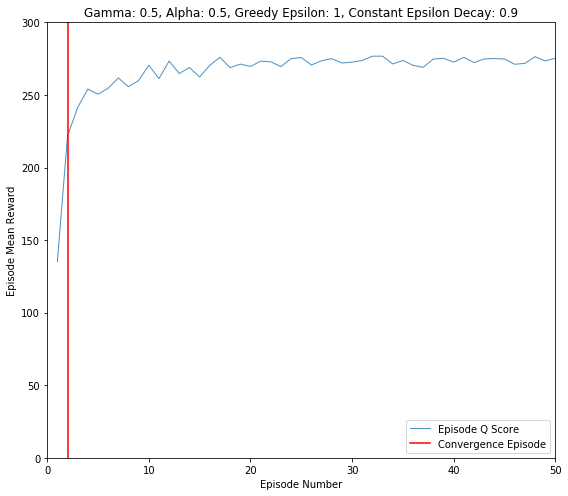

In [181]:
# Plot
plt.figure(figsize=(8,7))
x_episodes = np.linspace(1, max_episode_count, max_episode_count, endpoint=True)
conv_points_y = np.linspace(0, 400, 400, endpoint=True)
conv_points_x = [convergence_episode] * 400 

Q_line = plt.plot(x_episodes, episode_Q_store, alpha=0.8, linewidth=1, label = 'Episode Q Score')
conv_line = plt.plot(conv_points_x, conv_points_y, color='red', label = 'Convergence Episode')
plt.legend()
plt.title("Gamma: 0.5, Alpha: 0.5, Greedy Epsilon: 1, Constant Epsilon Decay: 0.9")
plt.ylim(0,300)
plt.xlim(0,50)
plt.xlabel('Episode Number')
plt.ylabel('Episode Mean Reward')

plt.tight_layout()
plt.show()

<a id='6.1-Grid-Search-Over-Epsilon-and-Decay-Rate'></a>

### 6.1 Grid Search over Epsilon and Decay Rate

In [184]:
# Initialise epsilon and epsilon decay rate (if greedy epsilon is 1, then have a random policy)
alpha_learning_rate = 0.5
gamma_discount_factor = 0.5

# Set grid search range
epsilon_decay_range_size = 5
epsilon_decay_range = np.linspace(0, epsilon_decay_range_size, epsilon_decay_range_size)

min_exploration_factor = 0

# Initisalise convergence parameter
convergence_parameter = 15

# Initialise array to store grid search over alpha and gamma for number of episodes until convergence
np_algorithm_convergence_count = np.zeros(shape=(epsilon_decay_range_size**2, 3))

# Initialise array to store grid search over alpha and gamma for episode Q-scores until convergence
np_Q_scores_matrix = [[[] for j in range(epsilon_decay_range_size)] for i in range(epsilon_decay_range_size)]

# Initialise array to store number of episodes before convergence for each set of alpha and gamma
episode_count = []

# Set gamma counter, gamma store and alpha store
e = 0

# Set maximum number of episodes to test
max_episode_count = 300

#Start grid search
for greedy_epsilon_loop in epsilon_decay_range:
    
    # Set alpha counter
    d = 0
      
    for greedy_epsilon_rate_loop in epsilon_decay_range:
        greedy_epsilon_rate = greedy_epsilon_rate_loop/(epsilon_decay_range_size*10)
        greedy_epsilon = greedy_epsilon_loop/epsilon_decay_range_size
    
        #Reset variables
        [Q_matrix_old, Q_matrix_new, start_location, current_state,
         algorithm_convergence, episode_convergence, episode] = funcVariablesReset()
        convergence_episode = 0
        convergence_episode_store = []
        reward_matrix_learning = [0]*reward_matrix
        Q_matrix_new_sum_store = []
        first = True
        episode_Q_store = []

        print('TESTING: Epsilon', greedy_epsilon, 'Decay', (1-greedy_epsilon_rate))
        
        while episode <= max_episode_count-1: 
        #and np.sum(reward_matrix_learning) < len(reward_matrix): 
        
            #print('Epsilon', greedy_epsilon, 'Decay', greedy_epsilon_rate)

            episode_Q_value_trial_store = []
    
            for t in range(1, trial_samples+1):
                # Iterate through each episode (full journey from London to Lakes)
                episode_Q_value = funcEpisode(
                    episode_convergence, current_state, Q_matrix_old, Q_matrix_new,
                    greedy_epsilon, alpha_learning_rate, gamma_discount_factor)

                episode_Q_value_trial_store.append(episode_Q_value)

            episode_Q_value_mean = np.mean(episode_Q_value_trial_store)
            Q_matrix_new_sum_store.append(round(np.sum(Q_matrix_new),1))
            
            #Update the Q score for that episode
            episode_Q_store.append(episode_Q_value_mean)

            #Record max Q value
            episode_max_Q = max(episode_Q_store)
        
            # Reduce the greedy epsilon by greedy epsilon rate
            greedy_epsilon = greedy_epsilon*(1-greedy_epsilon_rate)
            
            # Prevent greedy epsilon from becoming negative
            if greedy_epsilon < 0:
                greedy_epsilon = 0
            
            # Check if all possible paths have been explored
            if np.count_nonzero(reward_matrix) == np.count_nonzero(Q_matrix_old): 

                # If so, check if the new Q matrix is equivalent to the previous episode's
                if np.array_equiv(np.round(Q_matrix_new, decimals=3), np.round(Q_matrix_old, decimals=3)):  
                    convergence_episode = episode
                    convergence_episode_store.append(convergence_episode)
                else:
                    convergence_episode_store.append(0)
                    #print('Conv_ep',episode,'Qmatnewsum',round(np.sum(Q_matrix_new),1))
                    
            else:
                convergence_episode_store.append(0)
                #print('Conv_ep',episode,'Qmatnewsum',round(np.sum(Q_matrix_new),1))
                
            # Update Old Q matrix with new one for next iteration
            np.copyto(Q_matrix_old, Q_matrix_new)
            
            # Update the number of full journeys made
            episode +=1
            
            # If there have been more episodes than the convergence parameter and the minimum exploration time
            if episode >= convergence_parameter and episode >= min_exploration_factor:
                
                # Check if the value in the episode convergence store, convergence parameter positions previously is the same
                if Q_matrix_new_sum_store[episode-1] == Q_matrix_new_sum_store[episode-convergence_parameter]:
                    
                    # If the first time the previous condition has been met
                    if first == True:
                        # Update the convergence episode number
                        convergence_episode = episode - convergence_parameter
                        print('Algorithm converged in %d episodes' % convergence_episode)
                        row = e * (epsilon_decay_range_size) + d
                        np_algorithm_convergence_count[row][2] = convergence_episode
                        first = False

            else:
                convergence_episode = 0
            
            #Store metrics for the set of hyperparameters
            row = e * (epsilon_decay_range_size) + d
            np_algorithm_convergence_count[row][0] = 1-(greedy_epsilon_rate_loop/(epsilon_decay_range_size*10))
            np_algorithm_convergence_count[row][1] = greedy_epsilon_loop/epsilon_decay_range_size
            np_Q_scores_matrix[d][e] = episode_Q_store  

        d+=1
    e+=1

TESTING: Epsilon 0.0 Decay 1.0
Algorithm converged in 23 episodes
TESTING: Epsilon 0.0 Decay 0.975
Algorithm converged in 116 episodes
TESTING: Epsilon 0.0 Decay 0.95
Algorithm converged in 112 episodes
TESTING: Epsilon 0.0 Decay 0.925
Algorithm converged in 38 episodes
TESTING: Epsilon 0.0 Decay 0.9
Algorithm converged in 38 episodes
TESTING: Epsilon 0.25 Decay 1.0
Algorithm converged in 24 episodes
TESTING: Epsilon 0.25 Decay 0.975
Algorithm converged in 33 episodes
TESTING: Epsilon 0.25 Decay 0.95
Algorithm converged in 23 episodes
TESTING: Epsilon 0.25 Decay 0.925
Algorithm converged in 79 episodes
TESTING: Epsilon 0.25 Decay 0.9
Algorithm converged in 101 episodes
TESTING: Epsilon 0.5 Decay 1.0
Algorithm converged in 17 episodes
TESTING: Epsilon 0.5 Decay 0.975
Algorithm converged in 17 episodes
TESTING: Epsilon 0.5 Decay 0.95
Algorithm converged in 23 episodes
TESTING: Epsilon 0.5 Decay 0.925
Algorithm converged in 16 episodes
TESTING: Epsilon 0.5 Decay 0.9
Algorithm converged in

Text(60.0, 0.5, 'Decay Factor')

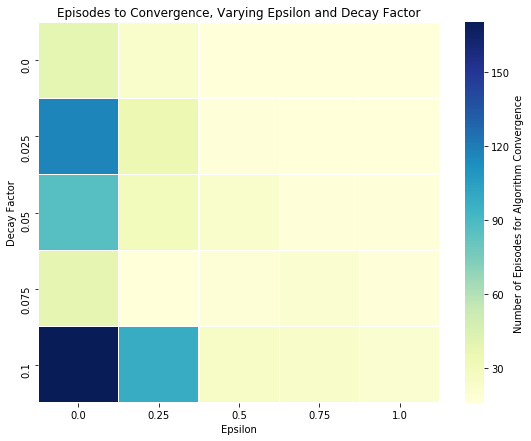

In [166]:
df_algorithm_convergence_count = pd.DataFrame(np_algorithm_convergence_count)
df_algorithm_convergence_count.columns=['Epsilon','Decay Rate','Episodes to Convergence']
df_algorithm_convergence_count
heatmap_epsilon_decay = df_algorithm_convergence_count.pivot('Epsilon', 'Decay Rate','Episodes to Convergence')

#heatmap_epsilon_decay.to_csv('heatmap_epsilon_decay_0.1_2.csv', index=False)
#heatmap_epsilon_decay = pd.read_csv('heatmap_epsilon_decay_0.1_2.csv')

plt.figure(figsize = (9,7))

ax = sns.heatmap(heatmap_epsilon_decay,
    linewidths=.5,
    vmax = max(np_algorithm_convergence_count[:,2]),
    cmap="YlGnBu",
    cbar_kws={'label': 'Number of Episodes for Algorithm Convergence'})

plt.title('Episodes to Convergence, Varying Epsilon and Decay Factor')
plt.xlabel('Epsilon')
plt.ylabel('Decay Factor')

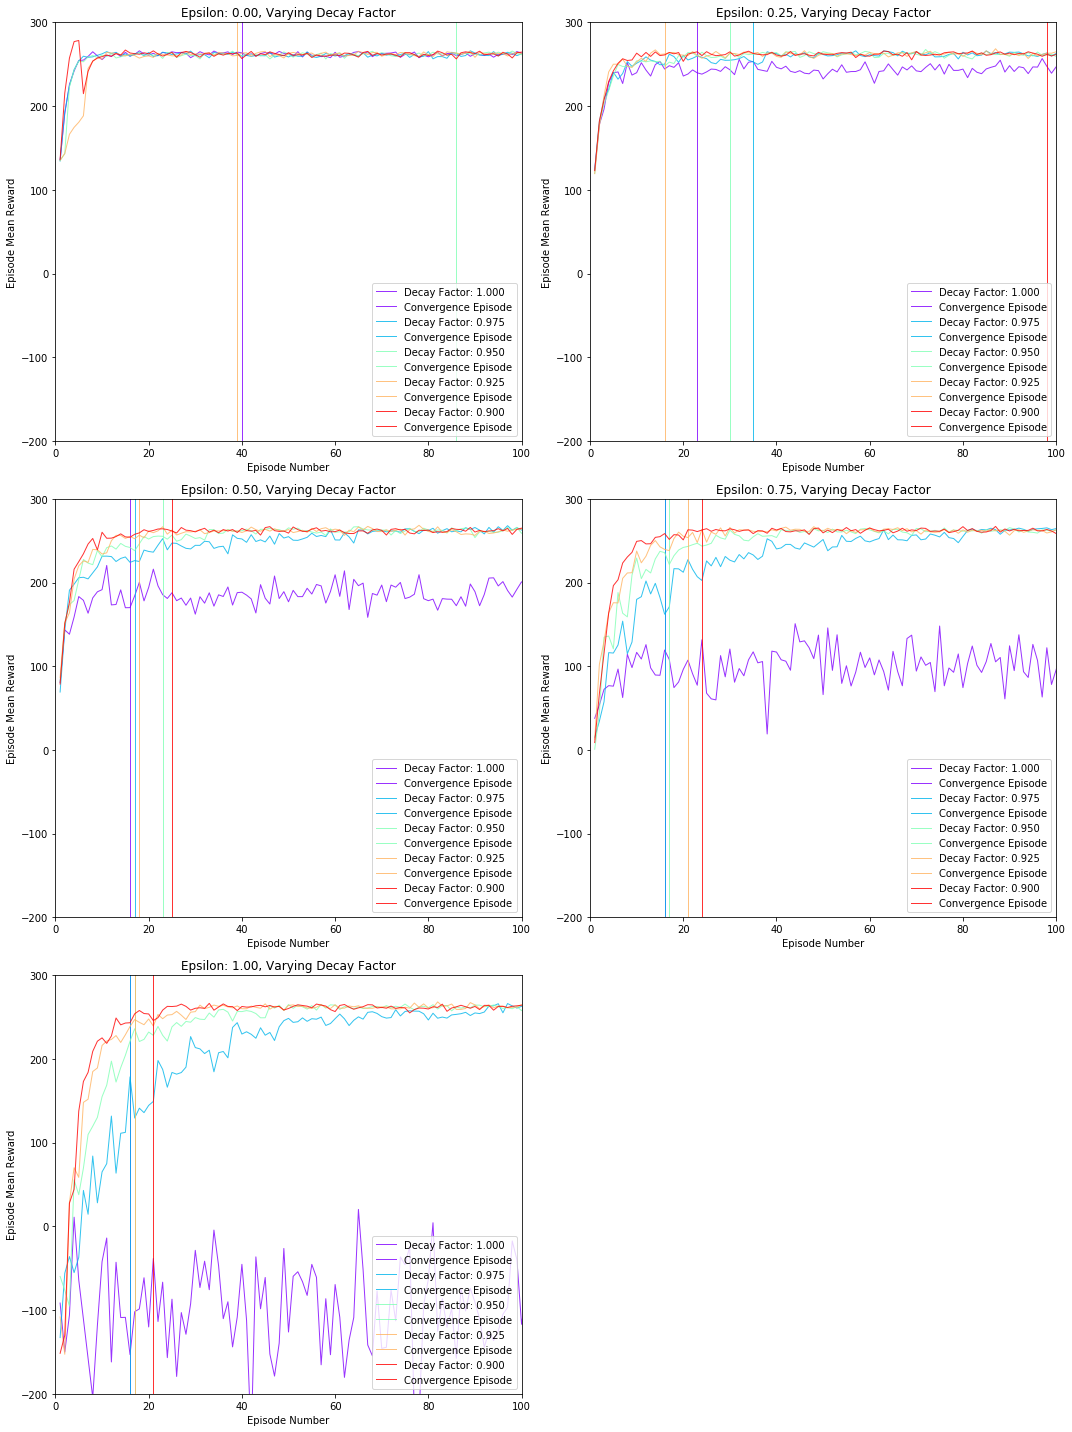

In [173]:
# Plot
fig = plt.figure(figsize=(15,20))

for e in range (0, len(np_Q_scores_matrix)):    
    
    ax = fig.add_subplot(len(np_Q_scores_matrix)/2+1,len(np_Q_scores_matrix)/2,e+1)   
    colour=iter(cm.rainbow(np.linspace(0,1,len(np_Q_scores_matrix))))
    
    for d in range (0, len(np_Q_scores_matrix)):
        c=next(colour)
        x_episodes = np.linspace(1, len(np_Q_scores_matrix[d][e]), len(np_Q_scores_matrix[d][e]), endpoint=True)
        row = e * (epsilon_decay_range_size) + d
        Q_line = ax.plot(x_episodes, np_Q_scores_matrix[d][e], alpha=0.8, c = c, linewidth=1, label = "Decay Factor: %0.3f" % (1-(epsilon_decay_range[d]/50)))
        plot_convergence_episode = int(np_algorithm_convergence_count[row][2])
        conv_points_y = np.linspace(-200, 400, 600, endpoint=True)
        conv_points_x = [plot_convergence_episode] * 600 
        conv_line = ax.plot(conv_points_x, conv_points_y,label = 'Convergence Episode', c=c, linewidth=1, alpha = 0.8)
        ax.legend(loc=4)
        ax.set_title("Epsilon: %.2f, Varying Decay Factor" % float((epsilon_decay_range[e])/5))
        ax.set_ylim(-200,300)
        ax.set_xlim(0,300)
        ax.set_xlabel('Episode Number')
        ax.set_ylabel('Episode Mean Reward')

plt.tight_layout()
plt.show()  

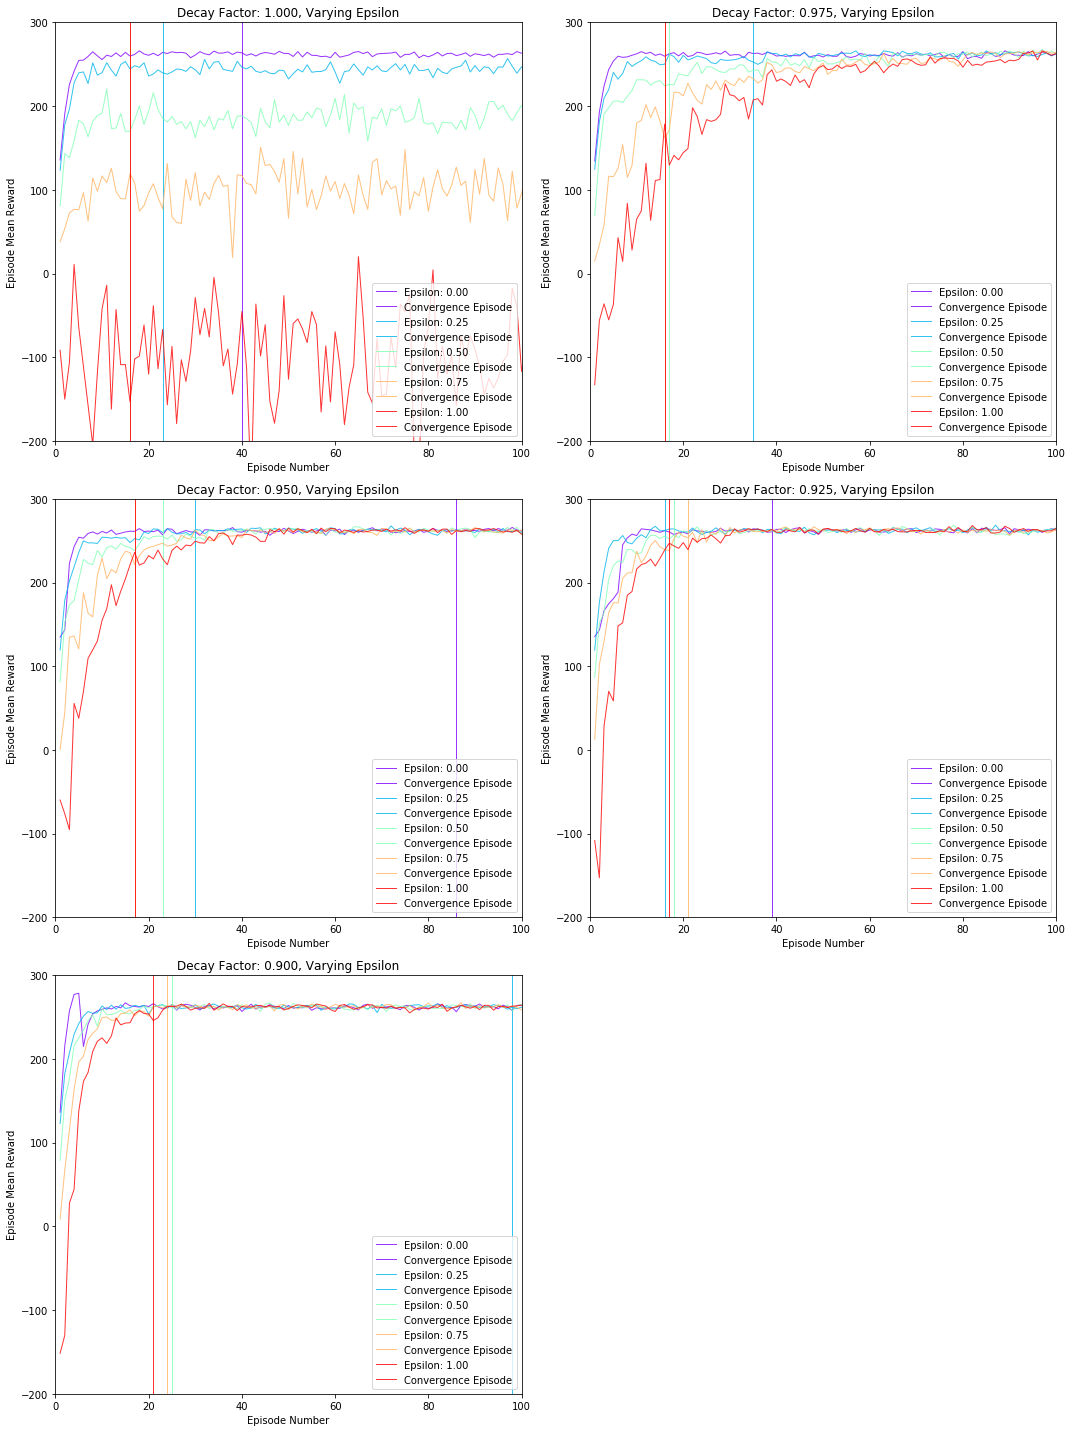

In [176]:
# Plot
fig = plt.figure(figsize=(15,20))

for d in range (0, len(np_Q_scores_matrix)):    
    
    ax = fig.add_subplot(len(np_Q_scores_matrix)/2+1,len(np_Q_scores_matrix)/2,d+1)   
    colour=iter(cm.rainbow(np.linspace(0,1,len(np_Q_scores_matrix))))
    
    for e in range (0, len(np_Q_scores_matrix)):
        c=next(colour)
        x_episodes = np.linspace(1, len(np_Q_scores_matrix[d][e]), len(np_Q_scores_matrix[d][e]), endpoint=True)
        row = e * (epsilon_decay_range_size) + d
        Q_line = ax.plot(x_episodes, np_Q_scores_matrix[d][e], alpha=0.8, c = c, linewidth=1, label = "Epsilon: %0.2f" % (epsilon_decay_range[e]/5))
        plot_convergence_episode = int(np_algorithm_convergence_count[row][2])
        conv_points_y = np.linspace(-200, 400, 600, endpoint=True)
        conv_points_x = [plot_convergence_episode] * 600 
        conv_line = ax.plot(conv_points_x, conv_points_y,label = 'Convergence Episode', c=c, linewidth=1, alpha = 0.8)
        ax.legend(loc=4)
        ax.set_title("Decay Factor: %.3f, Varying Epsilon" % ((1-(epsilon_decay_range[d])/50)))
        ax.set_ylim(-200,300)
        ax.set_xlim(0,100)
        ax.set_xlabel('Episode Number')
        ax.set_ylabel('Episode Mean Reward')

plt.tight_layout()
plt.show()  

<a id='6.2-Grid-Search-Over-Alpha-and-Gamma'></a>

### 6.2 Grid Search over Alpha and Gamma

In [177]:
# Initialise epsilon and epsilon decay rate
greedy_epsilon = 0.5
greedy_epsilon_rate = 0.1
#greedy_epsilon_rate_exploit = 0.5

#min_exploration_factor = 15

# Initisalise convergence parameter
convergence_parameter = 15

# Set grid search range
alpha_gamma_range_size = 5
alpha_gamma_range = np.linspace(0, alpha_gamma_range_size, alpha_gamma_range_size)

# Initialise array to store grid search over alpha and gamma for number of episodes until convergence
np_algorithm_convergence_count = np.zeros(shape=(alpha_gamma_range_size**2, 3))

# Initialise array to store grid search over alpha and gamma for episode Q-scores until convergence
np_Q_scores_matrix = [[[] for j in range(alpha_gamma_range_size)] for i in range(alpha_gamma_range_size)]

# Initialise array to store number of episodes before convergence for each set of alpha and gamma
episode_count = []

# Set gamma counter, gamma store and alpha store
g = 0

# Set maximum number of episodes to test
max_episode_count = 300

#Start grid search
for gamma_discount_factor in alpha_gamma_range:
    gamma_discount_factor = gamma_discount_factor/5
    
    # Set alpha counter
    a = 0
      
    for alpha_learning_rate in alpha_gamma_range:
        alpha_learning_rate = alpha_learning_rate/5
    
        #Reset variables
        [Q_matrix_old, Q_matrix_new, start_location, current_state,
         algorithm_convergence, episode_convergence, episode] = funcVariablesReset()
        greedy_epsilon = 0.5
        convergence_episode = 0
        convergence_episode_store = []
        reward_matrix_learning = [0]*reward_matrix
        Q_matrix_new_sum_store = []
        first = True
        episode_Q_store = []

        print('TESTING: Gamma', gamma_discount_factor, 'Alpha', alpha_learning_rate)
        
        while episode <= max_episode_count-1: 
        #and np.sum(reward_matrix_learning) < len(reward_matrix): 

            episode_Q_value_trial_store = []
    
            for t in range(1, trial_samples+1):
                # Iterate through each episode (full journey from London to Lakes)
                episode_Q_value = funcEpisode(
                    episode_convergence, current_state, Q_matrix_old, Q_matrix_new,
                    greedy_epsilon, alpha_learning_rate, gamma_discount_factor)

                episode_Q_value_trial_store.append(episode_Q_value)

            episode_Q_value_mean = np.mean(episode_Q_value_trial_store)
            Q_matrix_new_sum_store.append(round(np.sum(Q_matrix_new),1))
            
            #Update the Q score for that episode
            episode_Q_store.append(episode_Q_value_mean)

            #Record max Q value
            episode_max_Q = max(episode_Q_store)
            
            # Reduce the greedy epsilon by greedy epsilon rate
            greedy_epsilon = greedy_epsilon*(1-greedy_epsilon_rate)
            
            # Prevent greedy epsilon from becoming negative
            if greedy_epsilon < 0:
                greedy_epsilon = 0
            
            # Check if all possible paths have been explored
            if np.count_nonzero(reward_matrix) == np.count_nonzero(Q_matrix_old): 

                # If so, check if the new Q matrix is equivalent to the previous episode's
                if np.array_equiv(np.round(Q_matrix_new, decimals=3), np.round(Q_matrix_old, decimals=3)):  
                    convergence_episode = episode
                    convergence_episode_store.append(convergence_episode)
                else:
                    convergence_episode_store.append(0)
                    #print('Conv_ep',episode,'Qmatnewsum',round(np.sum(Q_matrix_new),1))
                    
            else:
                convergence_episode_store.append(0)
                #print('Conv_ep',episode,'Qmatnewsum',round(np.sum(Q_matrix_new),1))
                
            # Update Old Q matrix with new one for next iteration
            np.copyto(Q_matrix_old, Q_matrix_new)
            
            # Update the number of full journeys made
            episode +=1
            
            # If there have been more episodes than the convergence parameter and the minimum exploration time
            if episode >= convergence_parameter and episode >= min_exploration_factor:
                
                # Check if the value in the episode convergence store, convergence parameter positions previously is the same
                if Q_matrix_new_sum_store[episode-1] == Q_matrix_new_sum_store[episode-convergence_parameter]:
                    
                    # If the first time the previous condition has been met
                    if first == True:
                        # Update the convergence episode number
                        convergence_episode = episode - convergence_parameter
                        print('Algorithm converged in %d episodes' % convergence_episode)
                        row = g * (alpha_gamma_range_size) + a
                        np_algorithm_convergence_count[row][2] = convergence_episode
                        first = False

            else:
                convergence_episode = 0
            
            #Store metrics for the set of hyperparameters
            row = g * (alpha_gamma_range_size) + a
            np_algorithm_convergence_count[row][0] = alpha_learning_rate
            np_algorithm_convergence_count[row][1] = gamma_discount_factor
            np_Q_scores_matrix[a][g] = episode_Q_store  

        a+=1
    g+=1

TESTING: Gamma 0.0 Alpha 0.0
Algorithm converged in 0 episodes
TESTING: Gamma 0.0 Alpha 0.25
Algorithm converged in 39 episodes
TESTING: Gamma 0.0 Alpha 0.5
Algorithm converged in 44 episodes
TESTING: Gamma 0.0 Alpha 0.75
Algorithm converged in 8 episodes
TESTING: Gamma 0.0 Alpha 1.0
Algorithm converged in 0 episodes
TESTING: Gamma 0.25 Alpha 0.0
Algorithm converged in 0 episodes
TESTING: Gamma 0.25 Alpha 0.25
Algorithm converged in 14 episodes
TESTING: Gamma 0.25 Alpha 0.5
Algorithm converged in 13 episodes
TESTING: Gamma 0.25 Alpha 0.75
Algorithm converged in 12 episodes
TESTING: Gamma 0.25 Alpha 1.0
Algorithm converged in 3 episodes
TESTING: Gamma 0.5 Alpha 0.0
Algorithm converged in 0 episodes
TESTING: Gamma 0.5 Alpha 0.25
Algorithm converged in 64 episodes
TESTING: Gamma 0.5 Alpha 0.5
Algorithm converged in 21 episodes
TESTING: Gamma 0.5 Alpha 0.75
Algorithm converged in 12 episodes
TESTING: Gamma 0.5 Alpha 1.0
Algorithm converged in 4 episodes
TESTING: Gamma 0.75 Alpha 0.0
Algori

Text(60.0, 0.5, 'Alpha')

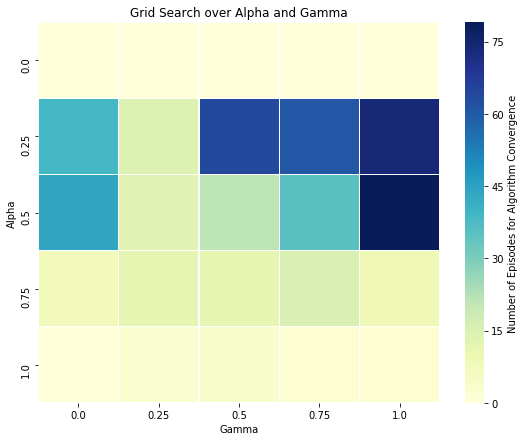

In [178]:
df_algorithm_convergence_count = pd.DataFrame(np_algorithm_convergence_count)
df_algorithm_convergence_count.columns=['Alpha','Gamma','Episodes to Convergence']
df_algorithm_convergence_count
heatmap_alpha_gamma = df_algorithm_convergence_count.pivot('Alpha', 'Gamma','Episodes to Convergence')

#heatmap_alpha_gamma.to_csv('heatmap_alpha_gamma_0.1_2.csv', index=False)
#heatmap_alpha_gamma = pd.read_csv('heatmap_alpha_gamma_0.1_2.csv')

plt.figure(figsize = (9,7))

ax = sns.heatmap(heatmap_alpha_gamma,
    linewidths=.5,
    vmax = max(np_algorithm_convergence_count[:,2]),
    cmap="YlGnBu",
    cbar_kws={'label': 'Number of Episodes for Algorithm Convergence'})

plt.title('Grid Search over Alpha and Gamma')
plt.xlabel('Gamma')
plt.ylabel('Alpha')

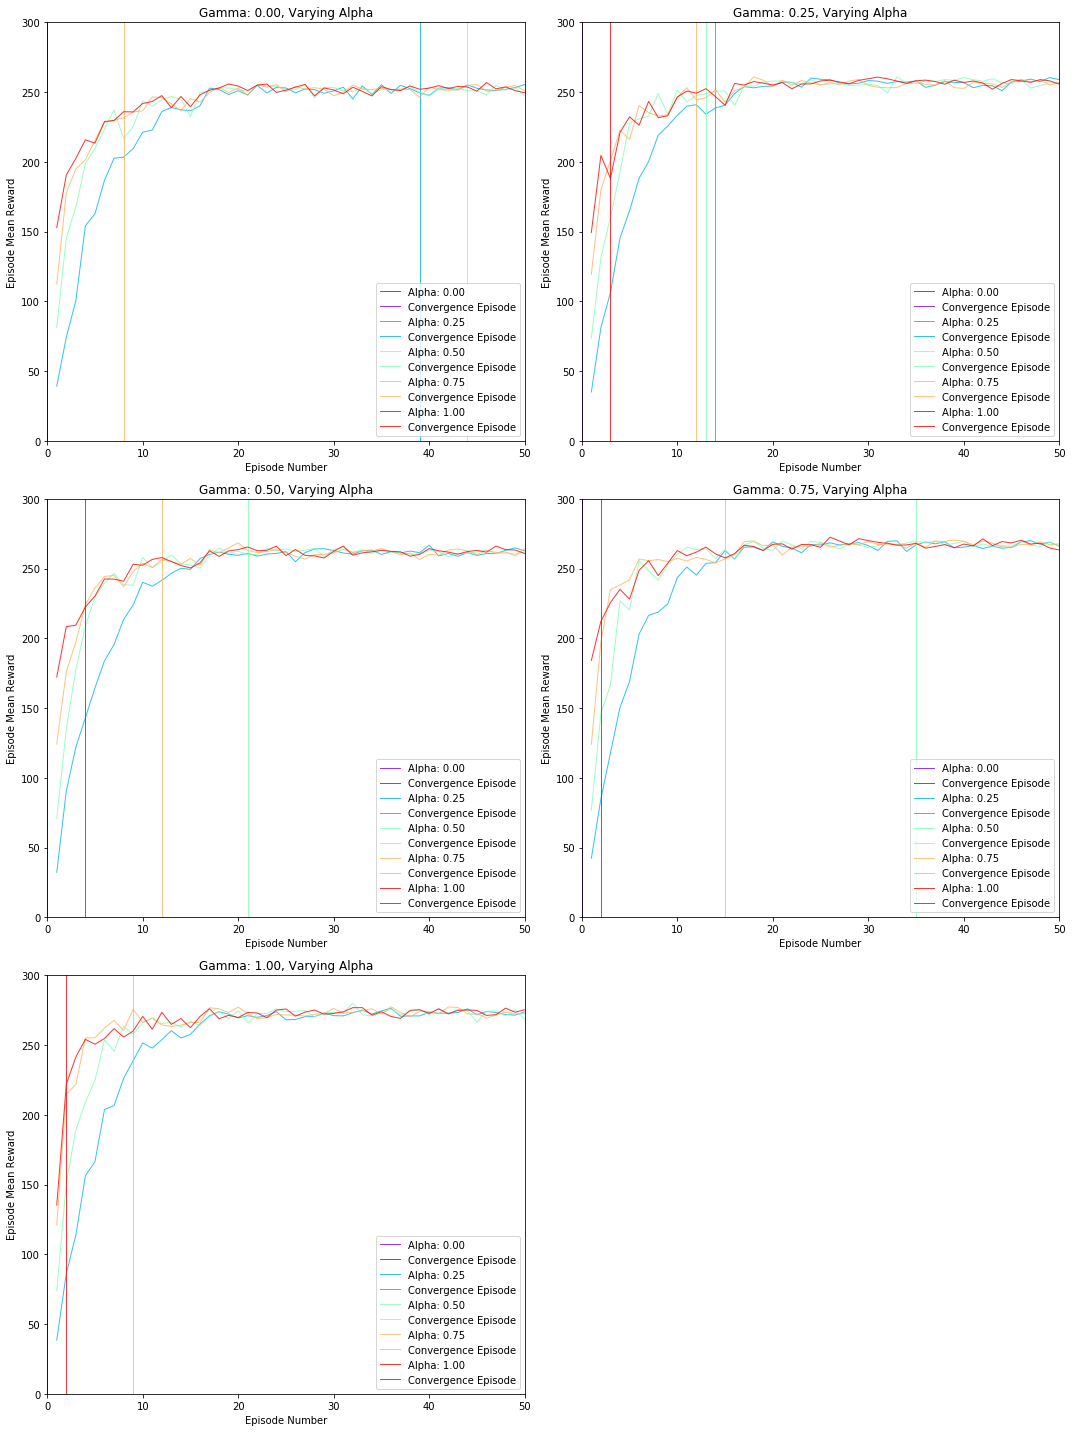

In [179]:
# Plot
fig = plt.figure(figsize=(15,20))

for g in range (0, len(np_Q_scores_matrix)):    
    
    ax = fig.add_subplot(len(np_Q_scores_matrix)/2+1,len(np_Q_scores_matrix)/2,g+1)   
    colour=iter(cm.rainbow(np.linspace(0,1,len(np_Q_scores_matrix))))
    
    for a in range (0, len(np_Q_scores_matrix)):
        c=next(colour)
        x_episodes = np.linspace(1, len(np_Q_scores_matrix[a][g]), len(np_Q_scores_matrix[a][g]), endpoint=True)
        row = g * (alpha_gamma_range_size) + a
        Q_line = ax.plot(x_episodes, np_Q_scores_matrix[a][g], alpha=0.8, c = c, linewidth=1, label = "Alpha: %0.2f" % (alpha_gamma_range[a]/5))
        plot_convergence_episode = int(np_algorithm_convergence_count[row][2])
        conv_points_y = np.linspace(0, 400, 400, endpoint=True)
        conv_points_x = [plot_convergence_episode] * 400 
        conv_line = ax.plot(conv_points_x, conv_points_y,label = 'Convergence Episode', c=c, linewidth=1, alpha = 0.8)
        ax.legend(loc=4)
        ax.set_title("Gamma: %0.2f, Varying Alpha" % (alpha_gamma_range[g]/5))
        ax.set_ylim(0,300)
        ax.set_xlim(0,50)
        ax.set_xlabel('Episode Number')
        ax.set_ylabel('Episode Mean Reward')

plt.tight_layout()
plt.show() 

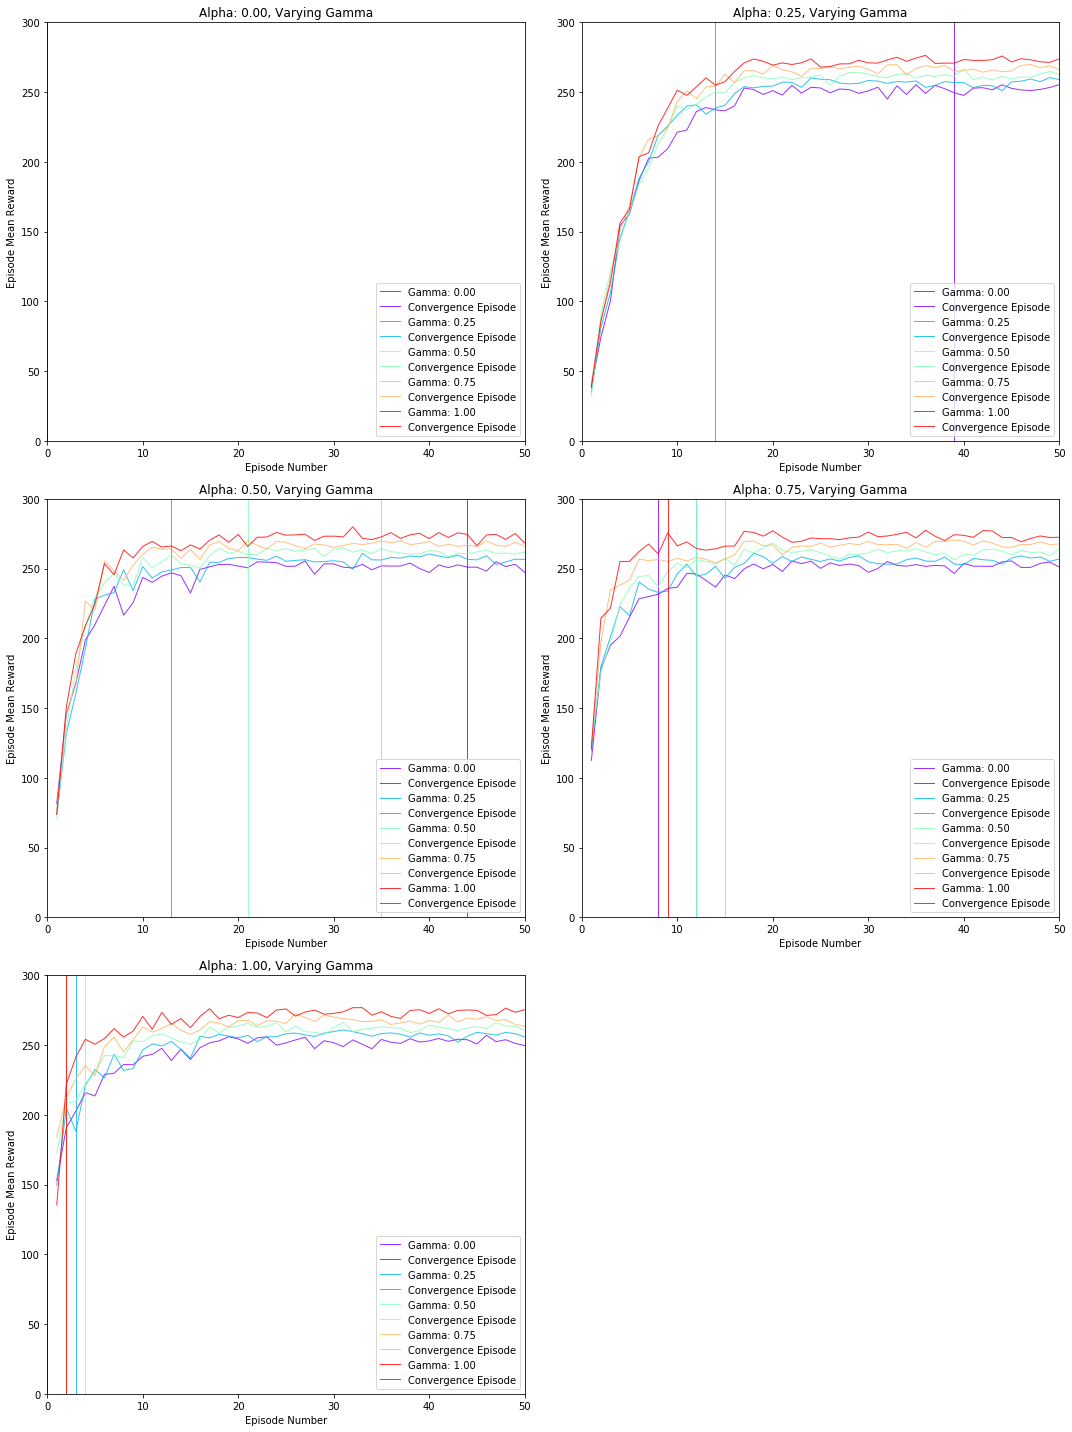

In [180]:
# Plot
fig = plt.figure(figsize=(15,20))

for a in range (0, len(np_Q_scores_matrix)):    
    
    ax = fig.add_subplot(len(np_Q_scores_matrix)/2+1,len(np_Q_scores_matrix)/2,a+1)   
    colour=iter(cm.rainbow(np.linspace(0,1,len(np_Q_scores_matrix))))
    
    for g in range (0, len(np_Q_scores_matrix)):
        c=next(colour)
        x_episodes = np.linspace(1, len(np_Q_scores_matrix[a][g]), len(np_Q_scores_matrix[a][g]), endpoint=True)
        row = g * (alpha_gamma_range_size) + a
        Q_line = ax.plot(x_episodes, np_Q_scores_matrix[a][g], alpha=0.8, c = c, linewidth=1, label = "Gamma: %0.2f" % (alpha_gamma_range[g]/5))
        plot_convergence_episode = int(np_algorithm_convergence_count[row][2])
        conv_points_y = np.linspace(0, 400, 400, endpoint=True)
        conv_points_x = [plot_convergence_episode] * 400 
        conv_line = ax.plot(conv_points_x, conv_points_y,label = 'Convergence Episode', c=c, linewidth=1, alpha = 0.8)
        ax.legend(loc=4)
        ax.set_title("Alpha: %0.2f, Varying Gamma" % (alpha_gamma_range[a]/5))
        ax.set_ylim(0,300)
        ax.set_xlim(0,50)
        ax.set_xlabel('Episode Number')
        ax.set_ylabel('Episode Mean Reward')

plt.tight_layout()
plt.show()